In [1]:
pip install torch diffusers transformers pandas numpy scipy scikit-learn torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Using: cuda
GPU Memory: 17.06 GB
Training new enhanced model...
Generated enhanced dataset with 10000 samples and power breakdown
Columns: ['timestamp', 'total_load', 'temp', 'humidity', 'holiday', 'solar', 'wind', 'spp_minihydro', 'spp_biomass', 'thermal_oil', 'major_hydro', 'coal']
Starting training for enhanced multi-output model...
Input dimension: 11
Output dimension: 10
Model parameters: 188,536

Debug shapes:
  cond: torch.Size([16, 24, 11])
  target: torch.Size([16, 12, 10])
  pred_noise_all: torch.Size([16, 12, 10])
  pred_noise_total: torch.Size([16, 12])
  pred_noise_sources: torch.Size([16, 12, 9])
Epoch 1/20:
  Total Loss: 2.0242
  Diffusion Loss: 2.0109
  Physics Loss: 0.0134
  Learning Rate: 9.05e-05
Epoch 2/20:
  Total Loss: 2.0074
  Diffusion Loss: 2.0062
  Physics Loss: 0.0012
  Learning Rate: 6.58e-05
  ⬇ Learning rate reduced to 9.05e-05
Epoch 3/20:
  Total Loss: 2.0037
  Diffusion Loss: 2.0030
  Physics Loss: 0.0008
  Learning Rate: 3.52e-05
  ⬇ Learning rate reduc

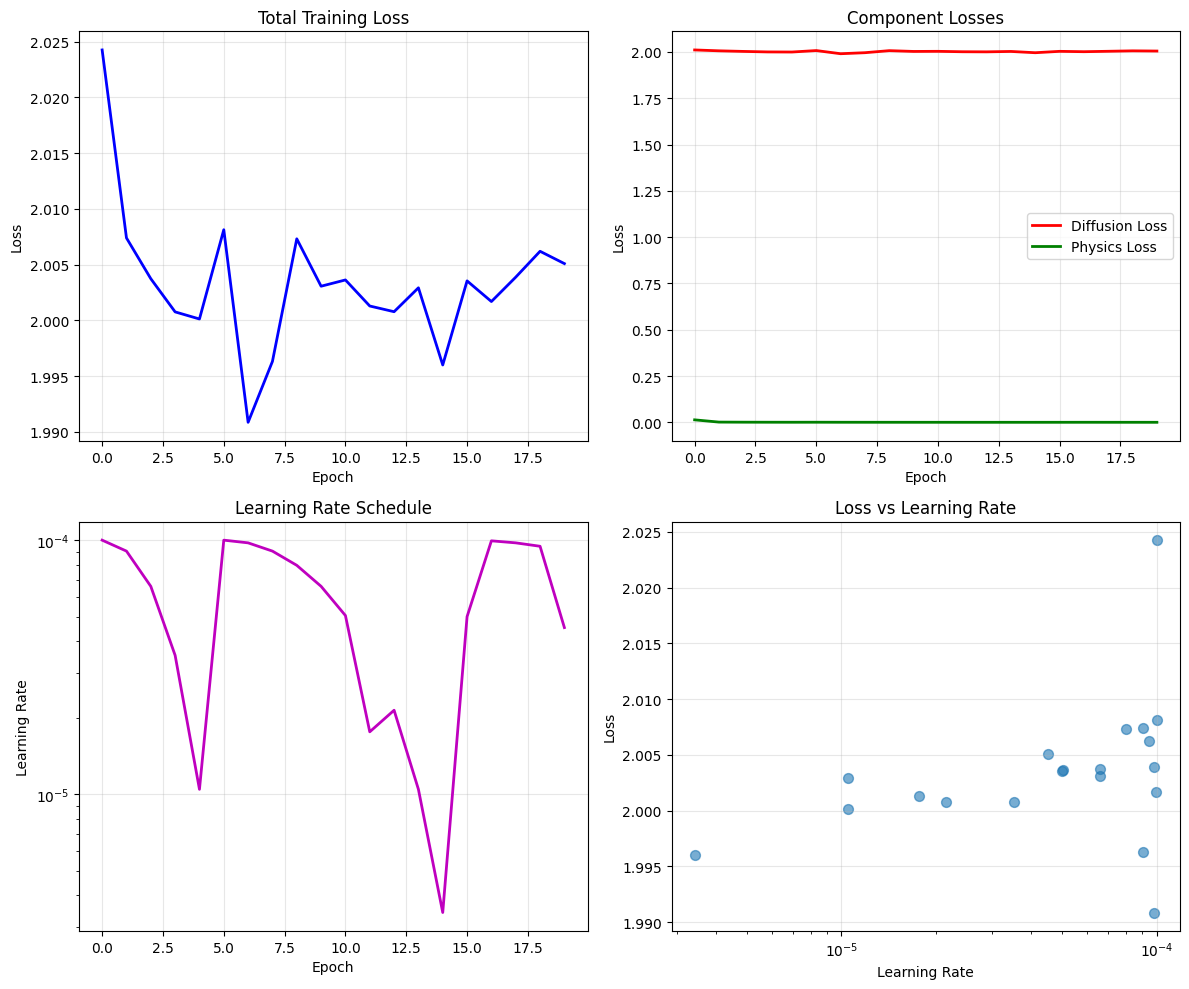

Enhanced model saved
Starting enhanced inference with uncertainty quantification (MC samples: 15)...
Processed sample 1
Processed sample 2
Processed sample 3
Processed sample 4
Processed sample 5
Processed sample 6
Processed sample 7
Processed sample 8

ENHANCED EVALUATION METRICS WITH UNCERTAINTY QUANTIFICATION (MW)
Source               MAE        RMSE       MAPE(%)    Coverage@80% Sharpness@80%
--------------------------------------------------------------------------------
total_load           5.4677     5.7163     68.49     87.5%        14.4696
solar                15.3418     16.0436     90.80     100.0%        70.1518
wind                 37.5221     41.7349     52.79     95.8%        148.9658
spp_minihydro        0.9650     1.1599     171.31     92.7%        3.9183
spp_biomass          0.6407     0.7440     84.52     100.0%        3.7962
thermal_oil          0.4817     0.5280     73.40     95.8%        1.7902
major_hydro          0.3621     0.3946     74.26     97.9%        1.40

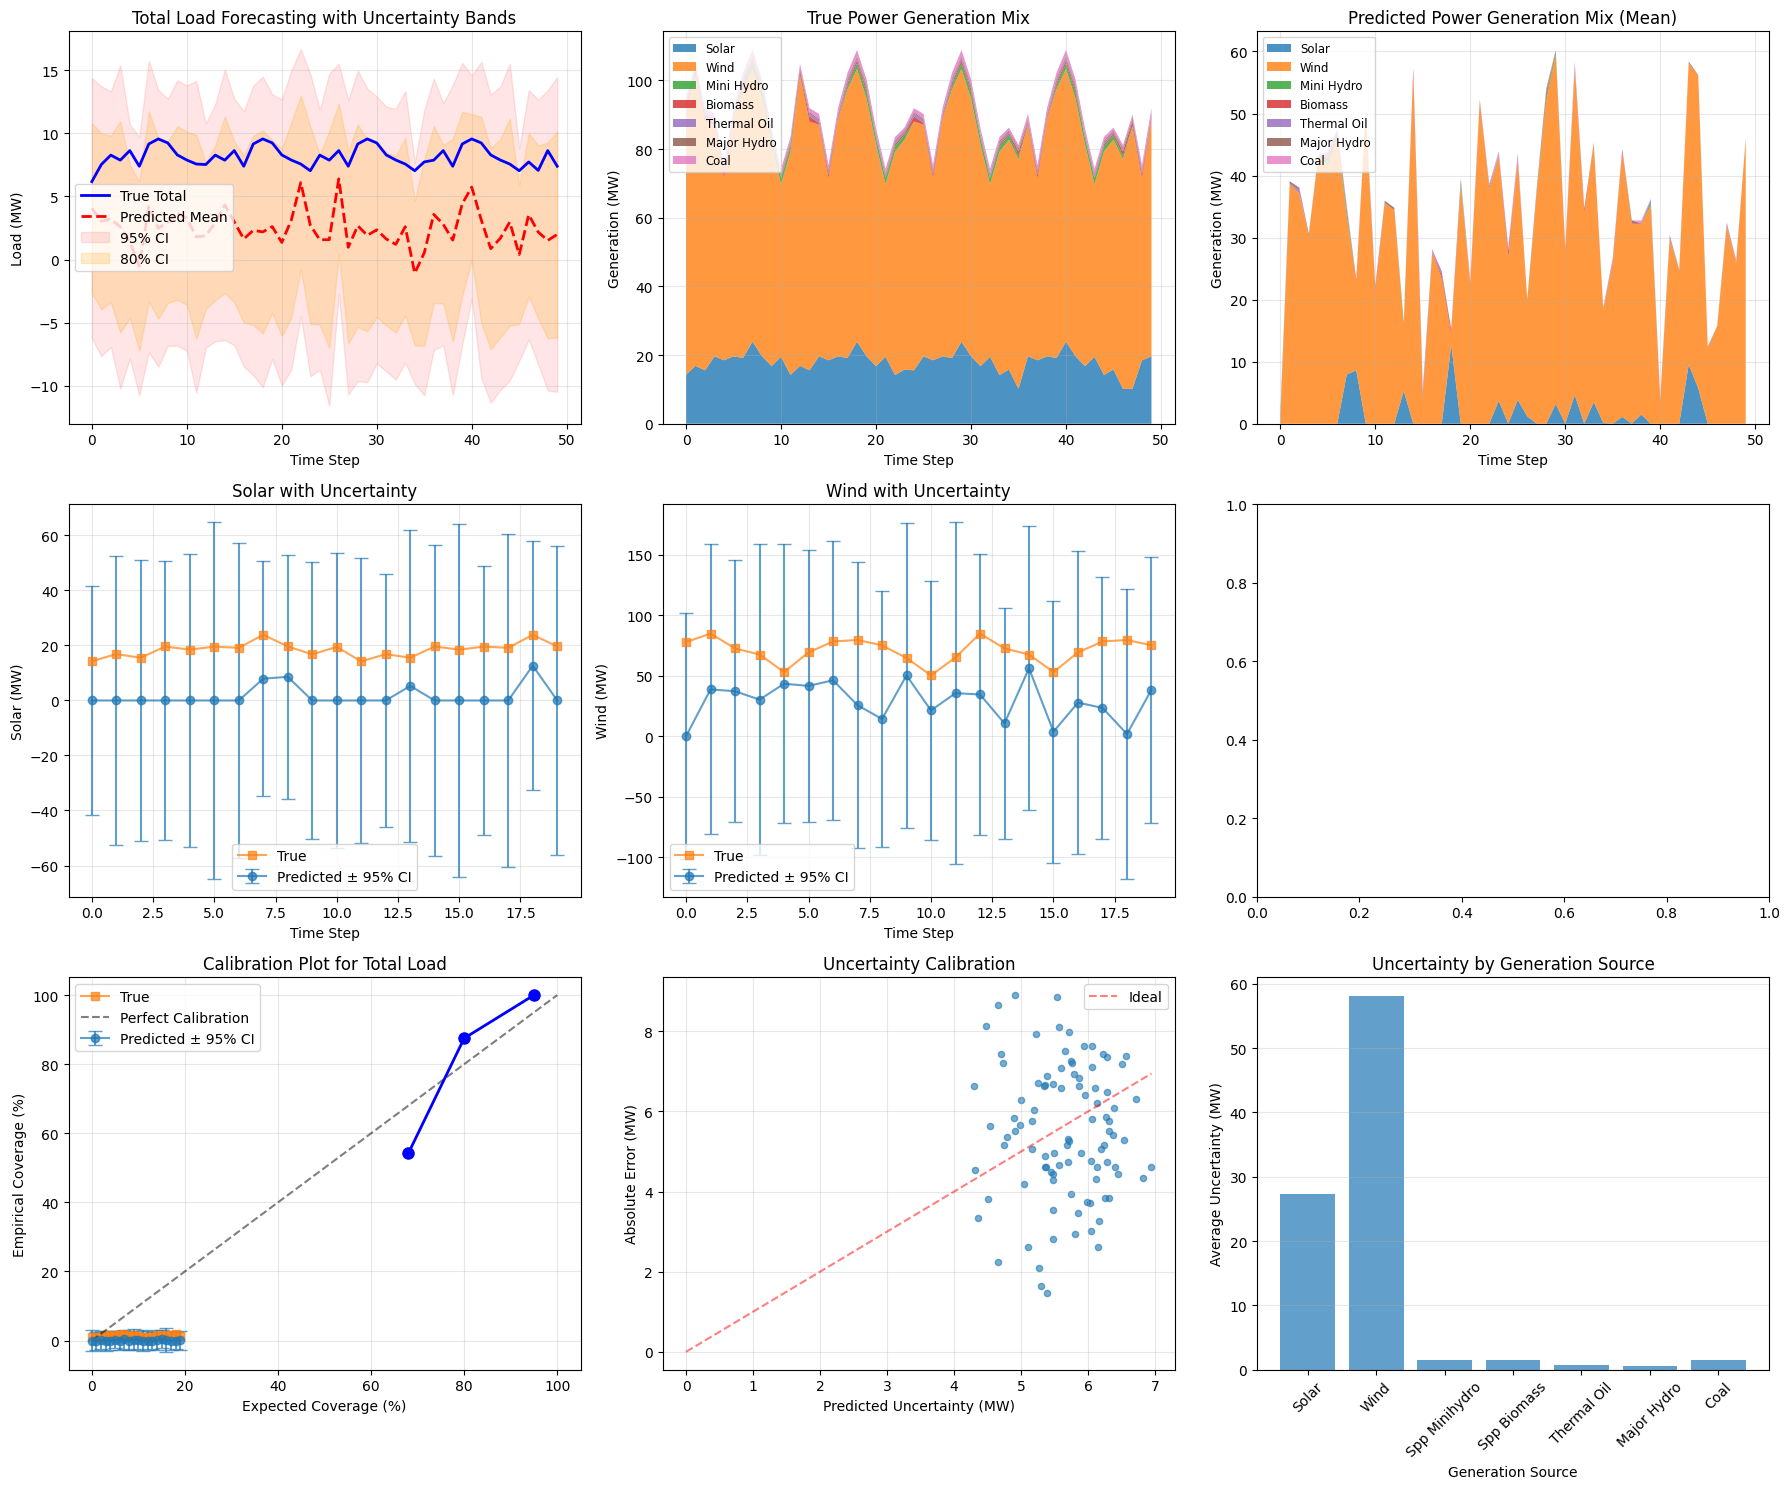

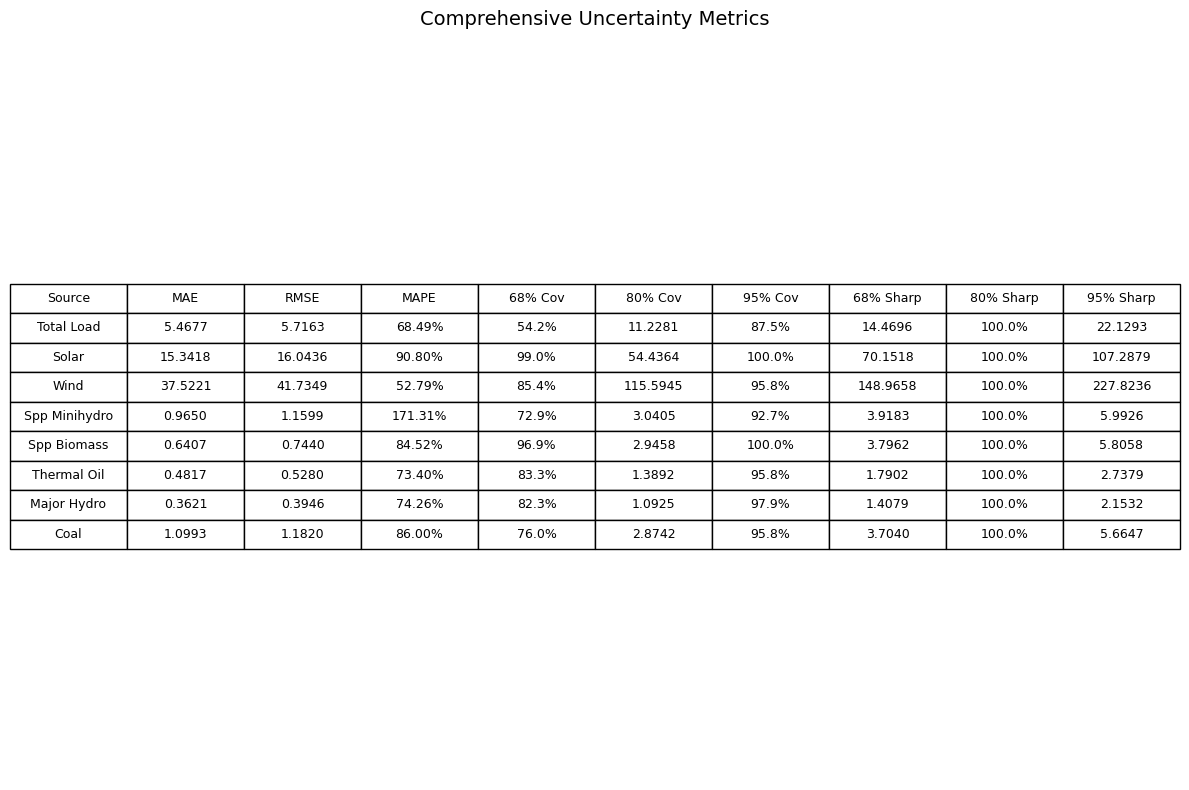


✅ Enhanced model with uncertainty quantification complete!


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from diffusers import DDPMScheduler
import warnings
import os
from scipy import stats
warnings.filterwarnings('ignore')

# Set memory optimization flags
torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()

# 1. Enhanced Sample Dataset Generation with Power Breakdown
def generate_gefcom_sample(n_samples=1500):
    np.random.seed(42)
    dates = pd.date_range('2025-01-01', periods=n_samples, freq='H')
    
    # Base load pattern (same as before)
    base_load = 4.5 + 1.2*np.sin(2*np.pi*dates.hour/24) + 0.8*np.sin(2*np.pi*(dates.dayofyear)/365)
    
    # Weather variables
    temp = 15 + 10*np.sin(2*np.pi*(dates.dayofyear)/365) + 5*np.sin(2*np.pi*dates.hour/24) + np.random.normal(0, 2, n_samples)
    humidity = 70 + np.random.normal(0, 10, n_samples)
    holiday = (dates.weekday >= 5).astype(int) + (dates.month == 12).astype(int)
    
    # Power generation breakdown (MW)
    # Solar: follows daylight pattern
    solar = np.zeros(n_samples)
    daytime = (dates.hour >= 6) & (dates.hour <= 18)
    solar[daytime] = 1.2 + 0.8*np.sin(2*np.pi*(dates.hour[daytime]-6)/12) + np.random.normal(0, 0.1, sum(daytime))
    solar[~daytime] = np.random.normal(0, 0.05, sum(~daytime))
    solar = np.maximum(solar, 0)
    
    # Wind: more variable
    wind = 0.8 + 0.4*np.sin(2*np.pi*dates.hour/12) + np.random.normal(0, 0.3, n_samples)
    wind = np.maximum(wind, 0)
    
    # SPP Minihydro: relatively stable with small variations
    minihydro = 0.6 + 0.2*np.sin(2*np.pi*dates.hour/24) + np.random.normal(0, 0.1, n_samples)
    minihydro = np.maximum(minihydro, 0)
    
    # SPP Biomass: stable baseload
    biomass = 0.5 + 0.1*np.random.normal(0, 1, n_samples)
    biomass = np.maximum(biomass, 0)
    
    # Thermal Oil: follows demand pattern
    thermal_oil = 1.0 + 0.5*np.sin(2*np.pi*dates.hour/24) + np.random.normal(0, 0.2, n_samples)
    thermal_oil = np.maximum(thermal_oil, 0)
    
    # Major Hydro: flexible generation
    major_hydro = 1.5 + 0.8*np.sin(2*np.pi*dates.hour/24) + np.random.normal(0, 0.3, n_samples)
    major_hydro = np.maximum(major_hydro, 0)
    
    # Coal: baseload with some variation
    coal = 2.0 + 0.5*np.sin(2*np.pi*dates.hour/12) + np.random.normal(0, 0.2, n_samples)
    coal = np.maximum(coal, 0)
    
    # Total load (sum of all generation + noise)
    total_load = base_load + np.random.normal(0, 0.3, n_samples)
    
    # Create DataFrame
    df = pd.DataFrame({
        'timestamp': dates,
        'total_load': total_load,
        'temp': temp,
        'humidity': humidity,
        'holiday': holiday,
        'solar': solar,
        'wind': wind,
        'spp_minihydro': minihydro,
        'spp_biomass': biomass,
        'thermal_oil': thermal_oil,
        'major_hydro': major_hydro,
        'coal': coal
    })
    
    # Verify sum matches total load (with small tolerance)
    generation_sum = df[['solar', 'wind', 'spp_minihydro', 'spp_biomass', 'thermal_oil', 'major_hydro', 'coal']].sum(axis=1)
    df['total_load'] = generation_sum  # Make total load equal to sum of generation
    
    df.to_csv('gefcom_sample_enhanced.csv', index=False)
    print(f"Generated enhanced dataset with {n_samples} samples and power breakdown")
    print(f"Columns: {df.columns.tolist()}")
    return df

# 2. Enhanced Dataset Class
class LoadDataset(Dataset):
    def __init__(self, csv_path, seq_len=24, pred_len=12, use_all_features=True):
        self.df = pd.read_csv(csv_path, parse_dates=['timestamp'])
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.use_all_features = use_all_features
        
        # Define features to scale (all numeric except holiday)
        numeric_cols = ['total_load', 'temp', 'humidity', 'solar', 'wind', 
                       'spp_minihydro', 'spp_biomass', 'thermal_oil', 
                       'major_hydro', 'coal']
        
        self.scaler = MinMaxScaler()
        scaled_features = self.scaler.fit_transform(self.df[numeric_cols])
        
        # Create feature matrix
        holiday = self.df['holiday'].values.reshape(-1, 1)
        self.data = np.hstack([scaled_features, holiday])
        
        # Store column indices for easy access
        self.col_indices = {
            'total_load': 0,
            'temp': 1,
            'humidity': 2,
            'solar': 3,
            'wind': 4,
            'spp_minihydro': 5,
            'spp_biomass': 6,
            'thermal_oil': 7,
            'major_hydro': 8,
            'coal': 9,
            'holiday': 10
        }
        
        self.input_dim = self.data.shape[1]
        
    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len - 1
    
    def __getitem__(self, idx):
        cond = torch.tensor(self.data[idx:idx+self.seq_len], dtype=torch.float32)
        # Target includes total load and all generation sources
        target = torch.tensor(self.data[idx+self.seq_len:idx+self.seq_len+self.pred_len, :10], dtype=torch.float32)
        return cond, target

# 3. TMSAB Block (unchanged)
class TMSAB(nn.Module):
    def __init__(self, d_model=32, n_heads=2):
        super().__init__()
        self.d_model = d_model
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True, dropout=0.1)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model*2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(d_model*2, d_model)
        )
        
    def forward(self, x):
        residual = x
        x = self.norm1(x)
        attn_out, _ = self.attn(x, x, x)
        x = residual + attn_out
        
        residual = x
        x = self.norm2(x)
        ffn_out = self.ffn(x)
        x = residual + ffn_out
        
        return x

# 4. Enhanced DALNet for Multi-Output Forecasting
class EnhancedDALNet(nn.Module):
    def __init__(self, input_dim=11, hidden_dim=64, timesteps=50, pred_len=12, output_dim=10):
        super().__init__()
        self.pred_len = pred_len
        self.output_dim = output_dim  # total_load + 9 generation sources
        
        self.scheduler = DDPMScheduler(
            num_train_timesteps=timesteps,
            beta_schedule="linear",
            prediction_type="epsilon"
        )
        
        # Enhanced encoder with more capacity
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.1)
        
        # TMSAB for temporal attention
        self.tmsab = TMSAB(d_model=hidden_dim)
        
        # Time embedding
        self.time_emb = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Multi-output decoder for all power sources
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim * 4),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim * 2, pred_len * output_dim)  # Output all sources
        )
        
    def forward(self, cond, noisy_target, t):
        B = cond.shape[0]
        
        # LSTM processing
        lstm_out, _ = self.lstm(cond)  # (B, seq_len, hidden_dim)
        
        # TMSAB on relevant timesteps
        tmsab_input = lstm_out[:, -self.pred_len:, :]  # (B, pred_len, hidden_dim)
        tmsab_out = self.tmsab(tmsab_input)  # (B, pred_len, hidden_dim)
        
        # Context vectors
        context_mean = tmsab_out.mean(dim=1)  # (B, hidden_dim)
        context_max = tmsab_out.max(dim=1).values  # (B, hidden_dim)
        
        # Time embedding
        t_emb = self.time_emb(t.float().unsqueeze(-1))  # (B, hidden_dim)
        
        # Combine all features
        combined = torch.cat([context_mean, context_max, t_emb], dim=1)  # (B, hidden_dim * 3)
        
        # Decode to multi-output
        decoded = self.decoder(combined)  # (B, pred_len * output_dim)
        
        # Reshape to (B, pred_len, output_dim)
        output = decoded.view(B, self.pred_len, self.output_dim)
        
        return output

# 5. Enhanced Physics Loss with Power Balance Constraint
def physics_loss(pred_loads, cond_loads, generation_preds):
    # pred_loads: (B, pred_len) - total load predictions
    # generation_preds: (B, pred_len, num_sources) - individual source predictions
    
    # Non-negativity for all predictions
    non_neg_total = F.relu(-pred_loads).mean()
    non_neg_sources = F.relu(-generation_preds).mean()
    
    # Power balance constraint: sum of sources should equal total load
    if generation_preds is not None:
        source_sum = generation_preds.sum(dim=-1)  # Sum across sources
        balance_loss = F.mse_loss(source_sum, pred_loads)
    else:
        balance_loss = 0
    
    # Smoothness constraints
    if pred_loads.size(1) > 1:
        load_diff = torch.diff(pred_loads, dim=1)
        smooth_load = torch.mean(load_diff**2)
        
        if generation_preds is not None:
            source_diff = torch.diff(generation_preds, dim=1)
            smooth_sources = torch.mean(source_diff**2)
        else:
            smooth_sources = 0
    else:
        smooth_load = 0
        smooth_sources = 0
    
    total_loss = (
        0.1 * non_neg_total +
        0.05 * non_neg_sources +
        0.5 * balance_loss +
        0.01 * smooth_load +
        0.005 * smooth_sources
    )
    
    return total_loss

# 6. Training Function for Multi-Output Model with Hyperparameter Tuning
def train_model(epoch_count=20):
    torch.cuda.empty_cache()
    
    # Generate enhanced data
    df = generate_gefcom_sample(n_samples=10000)
    dataset = LoadDataset('gefcom_sample_enhanced.csv', seq_len=24, pred_len=12)
    train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)
    
    # Initialize enhanced model
    model = EnhancedDALNet(
        input_dim=dataset.input_dim,
        pred_len=12,
        output_dim=10  # total_load + 9 generation sources
    ).cuda()
    
    # HYPERPARAMETER TUNING: Advanced optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    
    # HYPERPARAMETER TUNING: Learning rate schedulers
    # Cosine annealing with warm restarts
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=5, T_mult=2, eta_min=1e-6
    )
    
    # ReduceLROnPlateau as backup (fixed: removed verbose parameter)
    scheduler_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    
    print("Starting training for enhanced multi-output model...")
    print(f"Input dimension: {dataset.input_dim}")
    print(f"Output dimension: {model.output_dim}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Track training metrics
    train_losses = []
    train_diff_losses = []
    train_phys_losses = []
    learning_rates = []
    
    for epoch in range(epoch_count):
        model.train()
        total_loss = 0
        total_diff_loss = 0
        total_phys_loss = 0
        
        for batch_idx, (cond, target) in enumerate(train_loader):
            optimizer.zero_grad(set_to_none=True)
            
            cond, target = cond.cuda(), target.cuda()
            
            # Sample timestep
            t = torch.randint(0, model.scheduler.num_train_timesteps, (cond.size(0),), device='cuda')
            
            # Add noise to all targets
            noise = torch.randn_like(target)
            noisy_target = model.scheduler.add_noise(target, noise, t)
            
            # Forward pass - get predictions for all outputs
            pred_noise_all = model(cond, noisy_target, t)  # (B, pred_len, output_dim)
            
            # Split predictions
            pred_noise_total = pred_noise_all[:, :, 0]  # Total load noise prediction
            pred_noise_sources = pred_noise_all[:, :, 1:]  # Source noise predictions
            
            # Corresponding actual noise
            noise_total = noise[:, :, 0]
            noise_sources = noise[:, :, 1:]
            
            # Diffusion loss (MSE on noise prediction)
            diff_loss_total = F.mse_loss(pred_noise_total, noise_total)
            diff_loss_sources = F.mse_loss(pred_noise_sources, noise_sources)
            diff_loss = diff_loss_total + diff_loss_sources
            
            # Physics loss
            phys_loss = physics_loss(pred_noise_total, cond, pred_noise_sources)
            
            # Total loss
            loss = diff_loss + phys_loss
            
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            total_loss += loss.item()
            total_diff_loss += diff_loss.item()
            total_phys_loss += phys_loss.item()
            
            if batch_idx == 0 and epoch == 0:
                print(f"\nDebug shapes:")
                print(f"  cond: {cond.shape}")
                print(f"  target: {target.shape}")
                print(f"  pred_noise_all: {pred_noise_all.shape}")
                print(f"  pred_noise_total: {pred_noise_total.shape}")
                print(f"  pred_noise_sources: {pred_noise_sources.shape}")
            
            if batch_idx % 20 == 0:
                torch.cuda.empty_cache()
        
        # Calculate epoch metrics
        avg_loss = total_loss / len(train_loader)
        avg_diff_loss = total_diff_loss / len(train_loader)
        avg_phys_loss = total_phys_loss / len(train_loader)
        
        train_losses.append(avg_loss)
        train_diff_losses.append(avg_diff_loss)
        train_phys_losses.append(avg_phys_loss)
        learning_rates.append(optimizer.param_groups[0]['lr'])
        
        # Update schedulers
        scheduler_cosine.step()
        scheduler_plateau.step(avg_loss)
        
        print(f'Epoch {epoch+1}/{epoch_count}:')
        print(f'  Total Loss: {avg_loss:.4f}')
        print(f'  Diffusion Loss: {avg_diff_loss:.4f}')
        print(f'  Physics Loss: {avg_phys_loss:.4f}')
        print(f'  Learning Rate: {optimizer.param_groups[0]["lr"]:.2e}')
        
        # Print LR reduction if it happened
        if len(learning_rates) > 1 and learning_rates[-1] < learning_rates[-2]:
            print(f'  ⬇ Learning rate reduced to {learning_rates[-1]:.2e}')
        
        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = f'checkpoint_epoch_{epoch+1}.pt'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, checkpoint_path)
            print(f'  Checkpoint saved: {checkpoint_path}')
    
    # Save final model
    torch.save(model.state_dict(), 'enhanced_dalnet.pt')
    
    # Plot training curves
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    axes[0,0].plot(train_losses, 'b-', linewidth=2)
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].set_title('Total Training Loss')
    axes[0,0].grid(True, alpha=0.3)
    
    axes[0,1].plot(train_diff_losses, 'r-', linewidth=2, label='Diffusion Loss')
    axes[0,1].plot(train_phys_losses, 'g-', linewidth=2, label='Physics Loss')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].set_title('Component Losses')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    axes[1,0].plot(learning_rates, 'm-', linewidth=2)
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Learning Rate')
    axes[1,0].set_title('Learning Rate Schedule')
    axes[1,0].set_yscale('log')
    axes[1,0].grid(True, alpha=0.3)
    
    # Loss vs Learning Rate
    axes[1,1].scatter(learning_rates, train_losses, alpha=0.6, s=50)
    axes[1,1].set_xlabel('Learning Rate')
    axes[1,1].set_ylabel('Loss')
    axes[1,1].set_title('Loss vs Learning Rate')
    axes[1,1].set_xscale('log')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Enhanced model saved")
    
    return model, dataset.scaler, dataset.col_indices

# 7. Enhanced Evaluation Metrics with Uncertainty Quantification
def evaluate_metrics(y_true_dict, y_pred_dict, y_uncertainty_dict=None):
    metrics = {}
    
    # Calculate metrics for each power source
    for source in y_true_dict.keys():
        y_true = np.array(y_true_dict[source]).flatten()
        y_pred = np.array(y_pred_dict[source]).flatten()
        
        if len(y_true) > 0 and len(y_pred) > 0 and len(y_true) == len(y_pred):
            # Point forecast metrics
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            
            mask = y_true != 0
            if mask.any():
                mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
            else:
                mape = 0
            
            metrics[f'{source}_MAE'] = mae
            metrics[f'{source}_RMSE'] = rmse
            metrics[f'{source}_MAPE'] = mape
            
            # Uncertainty metrics if available
            if y_uncertainty_dict and source in y_uncertainty_dict:
                uncertainty = np.array(y_uncertainty_dict[source]).flatten()
                
                # Coverage metrics for different confidence levels
                for confidence in [0.68, 0.80, 0.95]:
                    z_score = stats.norm.ppf((1 + confidence) / 2)
                    lower = y_pred - z_score * uncertainty
                    upper = y_pred + z_score * uncertainty
                    
                    coverage = np.mean((y_true >= lower) & (y_true <= upper)) * 100
                    sharpness = np.mean(upper - lower)
                    
                    metrics[f'{source}_Coverage_{int(confidence*100)}'] = coverage
                    metrics[f'{source}_Sharpness_{int(confidence*100)}'] = sharpness
                    metrics[f'{source}_ACE_{int(confidence*100)}'] = np.abs(confidence*100 - coverage)
                
                # Continuous Ranked Probability Score (CRPS) approximation
                if len(y_pred) > 1:
                    # Simplified CRPS calculation
                    errors = y_true - y_pred
                    crps = np.mean(np.sqrt(errors**2 + uncertainty**2) - uncertainty/np.sqrt(np.pi))
                    metrics[f'{source}_CRPS'] = crps
    
    return metrics

# 8. Enhanced Inference with Uncertainty Quantification
def inference_and_visualize(model, scaler, col_indices, test_loader, n_monte_carlo=10):
    model.eval()
    torch.cuda.empty_cache()
    
    # Store predictions for all sources
    predictions_dict = {
        'total_load': [],
        'solar': [],
        'wind': [],
        'spp_minihydro': [],
        'spp_biomass': [],
        'thermal_oil': [],
        'major_hydro': [],
        'coal': []
    }
    
    uncertainty_dict = {
        'total_load': [],
        'solar': [],
        'wind': [],
        'spp_minihydro': [],
        'spp_biomass': [],
        'thermal_oil': [],
        'major_hydro': [],
        'coal': []
    }
    
    true_dict = {
        'total_load': [],
        'solar': [],
        'wind': [],
        'spp_minihydro': [],
        'spp_biomass': [],
        'thermal_oil': [],
        'major_hydro': [],
        'coal': []
    }
    
    print(f"Starting enhanced inference with uncertainty quantification (MC samples: {n_monte_carlo})...")
    
    with torch.no_grad():
        for batch_idx, (cond, target) in enumerate(test_loader):
            if batch_idx >= 8:  # Process fewer samples for memory
                break
                
            cond = cond.cuda()
            
            # Monte Carlo sampling for uncertainty
            all_samples = []
            
            for mc_sample in range(n_monte_carlo):
                torch.cuda.empty_cache()
                
                # Diffusion sampling for uncertainty
                x = torch.randn(1, model.pred_len, model.output_dim, device='cuda')
                
                # Fast denoising process
                for t in reversed(range(0, model.scheduler.num_train_timesteps, 25)):
                    t_tensor = torch.full((1,), t, device='cuda', dtype=torch.long)
                    noise_pred = model(cond, x, t_tensor)
                    
                    scheduler_output = model.scheduler.step(
                        noise_pred, 
                        t_tensor, 
                        x
                    )
                    x = scheduler_output.prev_sample
                
                all_samples.append(x.cpu().numpy()[0])
                
                if mc_sample % 2 == 0:
                    torch.cuda.empty_cache()
            
            # Process Monte Carlo samples
            all_samples = np.array(all_samples)  # (n_monte_carlo, pred_len, output_dim)
            
            # Calculate mean and standard deviation for each source
            for i, source in enumerate(predictions_dict.keys()):
                if i < all_samples.shape[2]:
                    source_samples = all_samples[:, :, i]  # (n_monte_carlo, pred_len)
                    
                    # Mean prediction
                    mean_pred = source_samples.mean(axis=0).flatten()
                    
                    # Uncertainty (standard deviation)
                    std_pred = source_samples.std(axis=0).flatten()
                    
                    # True values
                    true_vals = target[0, :, i].numpy().flatten()
                    
                    predictions_dict[source].extend(mean_pred.tolist())
                    uncertainty_dict[source].extend(std_pred.tolist())
                    true_dict[source].extend(true_vals.tolist())
            
            print(f"Processed sample {batch_idx + 1}")
            torch.cuda.empty_cache()
    
    # Rescale predictions and uncertainties
    source_names = ['total_load', 'solar', 'wind', 'spp_minihydro', 'spp_biomass', 
                   'thermal_oil', 'major_hydro', 'coal']
    
    true_rescaled = {}
    pred_rescaled = {}
    uncertainty_rescaled = {}
    
    for i, source in enumerate(source_names):
        if i < scaler.data_min_.shape[0]:
            # Get scaling parameters
            min_val = scaler.data_min_[i]
            range_val = scaler.data_range_[i]
            
            # Rescale
            true_rescaled[source] = np.array(true_dict[source]) * range_val + min_val
            pred_rescaled[source] = np.array(predictions_dict[source]) * range_val + min_val
            uncertainty_rescaled[source] = np.array(uncertainty_dict[source]) * range_val
            
            # Ensure non-negative values for generation sources
            if source != 'total_load':
                pred_rescaled[source] = np.maximum(pred_rescaled[source], 0)
    
    # Calculate comprehensive metrics with uncertainty
    metrics = evaluate_metrics(true_rescaled, pred_rescaled, uncertainty_rescaled)
    
    # Display metrics
    print("\n" + "="*80)
    print("ENHANCED EVALUATION METRICS WITH UNCERTAINTY QUANTIFICATION (MW)")
    print("="*80)
    print(f"{'Source':<20} {'MAE':<10} {'RMSE':<10} {'MAPE(%)':<10} {'Coverage@80%':<12} {'Sharpness@80%':<12}")
    print("-" * 80)
    
    for source in source_names:
        if f'{source}_MAE' in metrics:
            coverage = metrics.get(f'{source}_Coverage_80', 0)
            sharpness = metrics.get(f'{source}_Sharpness_80', 0)
            
            print(f"{source:<20} {metrics[f'{source}_MAE']:.4f}     "
                  f"{metrics[f'{source}_RMSE']:.4f}     "
                  f"{metrics[f'{source}_MAPE']:.2f}     "
                  f"{coverage:.1f}%        {sharpness:.4f}")
    
    # Enhanced Visualization with Uncertainty
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    
    # 1. Total load forecast with uncertainty bands
    n_show = min(50, len(true_rescaled['total_load']))
    
    # Plot with multiple confidence intervals
    axes[0,0].plot(true_rescaled['total_load'][:n_show], 'b-', label='True Total', linewidth=2)
    axes[0,0].plot(pred_rescaled['total_load'][:n_show], 'r--', label='Predicted Mean', linewidth=2)
    
    # 95% confidence interval
    lower_95 = pred_rescaled['total_load'][:n_show] - 1.96 * uncertainty_rescaled['total_load'][:n_show]
    upper_95 = pred_rescaled['total_load'][:n_show] + 1.96 * uncertainty_rescaled['total_load'][:n_show]
    axes[0,0].fill_between(range(n_show), lower_95, upper_95, alpha=0.1, color='red', label='95% CI')
    
    # 80% confidence interval
    lower_80 = pred_rescaled['total_load'][:n_show] - 1.28 * uncertainty_rescaled['total_load'][:n_show]
    upper_80 = pred_rescaled['total_load'][:n_show] + 1.28 * uncertainty_rescaled['total_load'][:n_show]
    axes[0,0].fill_between(range(n_show), lower_80, upper_80, alpha=0.2, color='orange', label='80% CI')
    
    axes[0,0].set_title('Total Load Forecasting with Uncertainty Bands')
    axes[0,0].set_xlabel('Time Step')
    axes[0,0].set_ylabel('Load (MW)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Power generation breakdown (true)
    axes[0,1].stackplot(range(n_show),
                       [true_rescaled['solar'][:n_show],
                        true_rescaled['wind'][:n_show],
                        true_rescaled['spp_minihydro'][:n_show],
                        true_rescaled['spp_biomass'][:n_show],
                        true_rescaled['thermal_oil'][:n_show],
                        true_rescaled['major_hydro'][:n_show],
                        true_rescaled['coal'][:n_show]],
                       labels=['Solar', 'Wind', 'Mini Hydro', 'Biomass', 'Thermal Oil', 'Major Hydro', 'Coal'],
                       alpha=0.8)
    axes[0,1].set_title('True Power Generation Mix')
    axes[0,1].set_xlabel('Time Step')
    axes[0,1].set_ylabel('Generation (MW)')
    axes[0,1].legend(loc='upper left', fontsize='small')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Power generation breakdown (predicted with uncertainty)
    axes[0,2].stackplot(range(n_show),
                       [pred_rescaled['solar'][:n_show],
                        pred_rescaled['wind'][:n_show],
                        pred_rescaled['spp_minihydro'][:n_show],
                        pred_rescaled['spp_biomass'][:n_show],
                        pred_rescaled['thermal_oil'][:n_show],
                        pred_rescaled['major_hydro'][:n_show],
                        pred_rescaled['coal'][:n_show]],
                       labels=['Solar', 'Wind', 'Mini Hydro', 'Biomass', 'Thermal Oil', 'Major Hydro', 'Coal'],
                       alpha=0.8)
    axes[0,2].set_title('Predicted Power Generation Mix (Mean)')
    axes[0,2].set_xlabel('Time Step')
    axes[0,2].set_ylabel('Generation (MW)')
    axes[0,2].legend(loc='upper left', fontsize='small')
    axes[0,2].grid(True, alpha=0.3)
    
    # 4-6. Uncertainty visualization for major sources
    major_sources = ['solar', 'wind', 'coal']
    for idx, source in enumerate(major_sources):
        row = 1 + idx // 2
        col = idx % 2
        
        axes[row, col].errorbar(range(min(20, n_show)),
                               pred_rescaled[source][:min(20, n_show)],
                               yerr=1.96 * uncertainty_rescaled[source][:min(20, n_show)],
                               fmt='o-', alpha=0.7, capsize=5, label='Predicted ± 95% CI')
        axes[row, col].plot(true_rescaled[source][:min(20, n_show)], 's-', alpha=0.7, label='True')
        axes[row, col].set_xlabel('Time Step')
        axes[row, col].set_ylabel(f'{source.replace("_", " ").title()} (MW)')
        axes[row, col].set_title(f'{source.replace("_", " ").title()} with Uncertainty')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)
    
    # 7. Calibration plot (reliability diagram)
    axes[2, 0].plot([0, 100], [0, 100], 'k--', alpha=0.5, label='Perfect Calibration')
    
    confidence_levels = [0.68, 0.80, 0.95]
    empirical_coverage = []
    
    for confidence in confidence_levels:
        coverage_key = f'total_load_Coverage_{int(confidence*100)}'
        if coverage_key in metrics:
            empirical_coverage.append(metrics[coverage_key])
        else:
            empirical_coverage.append(confidence * 100)
    
    axes[2, 0].plot([c*100 for c in confidence_levels], empirical_coverage, 'bo-', linewidth=2, markersize=8)
    axes[2, 0].set_xlabel('Expected Coverage (%)')
    axes[2, 0].set_ylabel('Empirical Coverage (%)')
    axes[2, 0].set_title('Calibration Plot for Total Load')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    # 8. Uncertainty vs Error scatter
    errors = np.abs(true_rescaled['total_load'] - pred_rescaled['total_load'])
    uncertainties = uncertainty_rescaled['total_load']
    
    axes[2, 1].scatter(uncertainties, errors, alpha=0.6, s=20)
    axes[2, 1].plot([0, max(uncertainties)], [0, max(uncertainties)], 'r--', alpha=0.5, label='Ideal')
    axes[2, 1].set_xlabel('Predicted Uncertainty (MW)')
    axes[2, 1].set_ylabel('Absolute Error (MW)')
    axes[2, 1].set_title('Uncertainty Calibration')
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3)
    
    # 9. Uncertainty distribution by source
    source_uncertainties = [np.mean(uncertainty_rescaled[s]) for s in source_names if s != 'total_load']
    source_labels = [s.replace('_', ' ').title() for s in source_names if s != 'total_load']
    
    axes[2, 2].bar(source_labels, source_uncertainties, alpha=0.7)
    axes[2, 2].set_xlabel('Generation Source')
    axes[2, 2].set_ylabel('Average Uncertainty (MW)')
    axes[2, 2].set_title('Uncertainty by Generation Source')
    axes[2, 2].tick_params(axis='x', rotation=45)
    axes[2, 2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('enhanced_dalnet_results_with_uncertainty.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Create uncertainty metrics table
    fig2, ax2 = plt.subplots(figsize=(12, 8))
    ax2.axis('tight')
    ax2.axis('off')
    
    table_data = []
    for source in source_names:
        row = [source.replace('_', ' ').title()]
        
        # Point metrics
        row.extend([
            f"{metrics.get(f'{source}_MAE', 0):.4f}",
            f"{metrics.get(f'{source}_RMSE', 0):.4f}",
            f"{metrics.get(f'{source}_MAPE', 0):.2f}%"
        ])
        
        # Uncertainty metrics
        for confidence in [68, 80, 95]:
            coverage = metrics.get(f'{source}_Coverage_{confidence}', 0)
            sharpness = metrics.get(f'{source}_Sharpness_{confidence}', 0)
            row.extend([f"{coverage:.1f}%", f"{sharpness:.4f}"])
        
        table_data.append(row)
    
    col_labels = ['Source', 'MAE', 'RMSE', 'MAPE'] + \
                [f'{c}% Cov' for c in [68, 80, 95]] + \
                [f'{c}% Sharp' for c in [68, 80, 95]]
    
    table = ax2.table(cellText=table_data,
                     colLabels=col_labels,
                     loc='center',
                     cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    
    ax2.set_title('Comprehensive Uncertainty Metrics', fontsize=14, pad=20)
    
    plt.tight_layout()
    plt.savefig('uncertainty_metrics_table.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return metrics

# 9. Main Execution
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using: {device}")
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    # Train or load enhanced model
    # if os.path.exists('enhanced_dalnet.pt'):
    #     print("Loading enhanced model...")
    #     dataset = LoadDataset('gefcom_sample_enhanced.csv')
    #     model = EnhancedDALNet(
    #         input_dim=dataset.input_dim,
    #         pred_len=12,
    #         output_dim=10
    #     ).to(device)
    #     model.load_state_dict(torch.load('enhanced_dalnet.pt', map_location=device))
    #     scaler = dataset.scaler
    #     col_indices = dataset.col_indices
    # else:
    print("Training new enhanced model...")
    model, scaler, col_indices = train_model(20)
    
    # Test with enhanced data
    test_dataset = LoadDataset('gefcom_sample_enhanced.csv', seq_len=24, pred_len=12)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    try:
        metrics = inference_and_visualize(model, scaler, col_indices, test_loader, n_monte_carlo=15)
        print("\n✅ Enhanced model with uncertainty quantification complete!")
    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()

## Do not touch

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from diffusers import DDPMScheduler
import warnings
import os
warnings.filterwarnings('ignore')

# Set memory optimization flags
torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()

# 1. Enhanced Sample Dataset Generation with Power Breakdown
def generate_gefcom_sample(n_samples=1500):
    np.random.seed(42)
    dates = pd.date_range('2025-01-01', periods=n_samples, freq='H')
    
    # Base load pattern (same as before)
    base_load = 4.5 + 1.2*np.sin(2*np.pi*dates.hour/24) + 0.8*np.sin(2*np.pi*(dates.dayofyear)/365)
    
    # Weather variables
    temp = 15 + 10*np.sin(2*np.pi*(dates.dayofyear)/365) + 5*np.sin(2*np.pi*dates.hour/24) + np.random.normal(0, 2, n_samples)
    humidity = 70 + np.random.normal(0, 10, n_samples)
    holiday = (dates.weekday >= 5).astype(int) + (dates.month == 12).astype(int)
    
    # Power generation breakdown (MW)
    # Solar: follows daylight pattern
    solar = np.zeros(n_samples)
    daytime = (dates.hour >= 6) & (dates.hour <= 18)
    solar[daytime] = 1.2 + 0.8*np.sin(2*np.pi*(dates.hour[daytime]-6)/12) + np.random.normal(0, 0.1, sum(daytime))
    solar[~daytime] = np.random.normal(0, 0.05, sum(~daytime))
    solar = np.maximum(solar, 0)
    
    # Wind: more variable
    wind = 0.8 + 0.4*np.sin(2*np.pi*dates.hour/12) + np.random.normal(0, 0.3, n_samples)
    wind = np.maximum(wind, 0)
    
    # SPP Minihydro: relatively stable with small variations
    minihydro = 0.6 + 0.2*np.sin(2*np.pi*dates.hour/24) + np.random.normal(0, 0.1, n_samples)
    minihydro = np.maximum(minihydro, 0)
    
    # SPP Biomass: stable baseload
    biomass = 0.5 + 0.1*np.random.normal(0, 1, n_samples)
    biomass = np.maximum(biomass, 0)
    
    # Thermal Oil: follows demand pattern
    thermal_oil = 1.0 + 0.5*np.sin(2*np.pi*dates.hour/24) + np.random.normal(0, 0.2, n_samples)
    thermal_oil = np.maximum(thermal_oil, 0)
    
    # Major Hydro: flexible generation
    major_hydro = 1.5 + 0.8*np.sin(2*np.pi*dates.hour/24) + np.random.normal(0, 0.3, n_samples)
    major_hydro = np.maximum(major_hydro, 0)
    
    # Coal: baseload with some variation
    coal = 2.0 + 0.5*np.sin(2*np.pi*dates.hour/12) + np.random.normal(0, 0.2, n_samples)
    coal = np.maximum(coal, 0)
    
    # Total load (sum of all generation + noise)
    total_load = base_load + np.random.normal(0, 0.3, n_samples)
    
    # Create DataFrame
    df = pd.DataFrame({
        'timestamp': dates,
        'total_load': total_load,
        'temp': temp,
        'humidity': humidity,
        'holiday': holiday,
        'solar': solar,
        'wind': wind,
        'spp_minihydro': minihydro,
        'spp_biomass': biomass,
        'thermal_oil': thermal_oil,
        'major_hydro': major_hydro,
        'coal': coal
    })
    
    # Verify sum matches total load (with small tolerance)
    generation_sum = df[['solar', 'wind', 'spp_minihydro', 'spp_biomass', 'thermal_oil', 'major_hydro', 'coal']].sum(axis=1)
    df['total_load'] = generation_sum  # Make total load equal to sum of generation
    
    df.to_csv('gefcom_sample_enhanced.csv', index=False)
    print(f"Generated enhanced dataset with {n_samples} samples and power breakdown")
    print(f"Columns: {df.columns.tolist()}")
    return df

# 2. Enhanced Dataset Class
class LoadDataset(Dataset):
    def __init__(self, csv_path, seq_len=24, pred_len=12, use_all_features=True):
        self.df = pd.read_csv(csv_path, parse_dates=['timestamp'])
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.use_all_features = use_all_features
        
        # Define features to scale (all numeric except holiday)
        numeric_cols = ['total_load', 'temp', 'humidity', 'solar', 'wind', 
                       'spp_minihydro', 'spp_biomass', 'thermal_oil', 
                       'major_hydro', 'coal']
        
        self.scaler = MinMaxScaler()
        scaled_features = self.scaler.fit_transform(self.df[numeric_cols])
        
        # Create feature matrix
        holiday = self.df['holiday'].values.reshape(-1, 1)
        self.data = np.hstack([scaled_features, holiday])
        
        # Store column indices for easy access
        self.col_indices = {
            'total_load': 0,
            'temp': 1,
            'humidity': 2,
            'solar': 3,
            'wind': 4,
            'spp_minihydro': 5,
            'spp_biomass': 6,
            'thermal_oil': 7,
            'major_hydro': 8,
            'coal': 9,
            'holiday': 10
        }
        
        self.input_dim = self.data.shape[1]
        
    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len - 1
    
    def __getitem__(self, idx):
        cond = torch.tensor(self.data[idx:idx+self.seq_len], dtype=torch.float32)
        # Target includes total load and all generation sources
        target = torch.tensor(self.data[idx+self.seq_len:idx+self.seq_len+self.pred_len, :10], dtype=torch.float32)
        return cond, target

# 3. TMSAB Block (unchanged)
class TMSAB(nn.Module):
    def __init__(self, d_model=32, n_heads=2):
        super().__init__()
        self.d_model = d_model
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True, dropout=0.1)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model*2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(d_model*2, d_model)
        )
        
    def forward(self, x):
        residual = x
        x = self.norm1(x)
        attn_out, _ = self.attn(x, x, x)
        x = residual + attn_out
        
        residual = x
        x = self.norm2(x)
        ffn_out = self.ffn(x)
        x = residual + ffn_out
        
        return x

# 4. Enhanced DALNet for Multi-Output Forecasting
class EnhancedDALNet(nn.Module):
    def __init__(self, input_dim=11, hidden_dim=64, timesteps=50, pred_len=12, output_dim=10):
        super().__init__()
        self.pred_len = pred_len
        self.output_dim = output_dim  # total_load + 9 generation sources
        
        self.scheduler = DDPMScheduler(
            num_train_timesteps=timesteps,
            beta_schedule="linear",
            prediction_type="epsilon"
        )
        
        # Enhanced encoder with more capacity
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.1)
        
        # TMSAB for temporal attention
        self.tmsab = TMSAB(d_model=hidden_dim)
        
        # Time embedding
        self.time_emb = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Multi-output decoder for all power sources
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim * 4),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim * 2, pred_len * output_dim)  # Output all sources
        )
        
        # Separate heads for each output type (optional)
        self.output_heads = nn.ModuleList([
            nn.Linear(pred_len * output_dim, pred_len) for _ in range(output_dim)
        ])
        
    def forward(self, cond, noisy_target, t):
        B = cond.shape[0]
        
        # LSTM processing
        lstm_out, _ = self.lstm(cond)  # (B, seq_len, hidden_dim)
        
        # TMSAB on relevant timesteps
        tmsab_input = lstm_out[:, -self.pred_len:, :]  # (B, pred_len, hidden_dim)
        tmsab_out = self.tmsab(tmsab_input)  # (B, pred_len, hidden_dim)
        
        # Context vectors
        context_mean = tmsab_out.mean(dim=1)  # (B, hidden_dim)
        context_max = tmsab_out.max(dim=1).values  # (B, hidden_dim)
        
        # Time embedding
        t_emb = self.time_emb(t.float().unsqueeze(-1))  # (B, hidden_dim)
        
        # Combine all features
        combined = torch.cat([context_mean, context_max, t_emb], dim=1)  # (B, hidden_dim * 3)
        
        # Decode to multi-output
        decoded = self.decoder(combined)  # (B, pred_len * output_dim)
        
        # Reshape to (B, pred_len, output_dim)
        output = decoded.view(B, self.pred_len, self.output_dim)
        
        # If using separate heads
        # outputs = [head(decoded).unsqueeze(-1) for head in self.output_heads]
        # output = torch.cat(outputs, dim=-1)  # (B, pred_len, output_dim)
        
        return output

# 5. Enhanced Physics Loss with Power Balance Constraint
def physics_loss(pred_loads, cond_loads, generation_preds):
    # pred_loads: (B, pred_len) - total load predictions
    # generation_preds: (B, pred_len, num_sources) - individual source predictions
    
    # Non-negativity for all predictions
    non_neg_total = F.relu(-pred_loads).mean()
    non_neg_sources = F.relu(-generation_preds).mean()
    
    # Power balance constraint: sum of sources should equal total load
    if generation_preds is not None:
        source_sum = generation_preds.sum(dim=-1)  # Sum across sources
        balance_loss = F.mse_loss(source_sum, pred_loads)
    else:
        balance_loss = 0
    
    # Smoothness constraints
    if pred_loads.size(1) > 1:
        load_diff = torch.diff(pred_loads, dim=1)
        smooth_load = torch.mean(load_diff**2)
        
        if generation_preds is not None:
            source_diff = torch.diff(generation_preds, dim=1)
            smooth_sources = torch.mean(source_diff**2)
        else:
            smooth_sources = 0
    else:
        smooth_load = 0
        smooth_sources = 0
    
    total_loss = (
        0.1 * non_neg_total +
        0.05 * non_neg_sources +
        0.5 * balance_loss +
        0.01 * smooth_load +
        0.005 * smooth_sources
    )
    
    return total_loss

# 6. Training Function for Multi-Output Model
def train_model(epoch_count):
    torch.cuda.empty_cache()
    
    # Generate enhanced data
    df = generate_gefcom_sample(n_samples=10000)
    dataset = LoadDataset('gefcom_sample_enhanced.csv', seq_len=24, pred_len=12)
    train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)
    
    # Initialize enhanced model
    model = EnhancedDALNet(
        input_dim=dataset.input_dim,
        pred_len=12,
        output_dim=10  # total_load + 9 generation sources
    ).cuda()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    
    print("Starting training for enhanced multi-output model...")
    print(f"Input dimension: {dataset.input_dim}")
    print(f"Output dimension: {model.output_dim}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    for epoch in range(epoch_count):
        model.train()
        total_loss = 0
        
        for batch_idx, (cond, target) in enumerate(train_loader):
            optimizer.zero_grad(set_to_none=True)
            
            cond, target = cond.cuda(), target.cuda()
            
            # Sample timestep
            t = torch.randint(0, model.scheduler.num_train_timesteps, (cond.size(0),), device='cuda')
            
            # Add noise to all targets
            noise = torch.randn_like(target)
            noisy_target = model.scheduler.add_noise(target, noise, t)
            
            # Forward pass - get predictions for all outputs
            pred_noise_all = model(cond, noisy_target, t)  # (B, pred_len, output_dim)
            
            # Split predictions
            pred_noise_total = pred_noise_all[:, :, 0]  # Total load noise prediction
            pred_noise_sources = pred_noise_all[:, :, 1:]  # Source noise predictions
            
            # Corresponding actual noise
            noise_total = noise[:, :, 0]
            noise_sources = noise[:, :, 1:]
            
            # Diffusion loss (MSE on noise prediction)
            diff_loss_total = F.mse_loss(pred_noise_total, noise_total)
            diff_loss_sources = F.mse_loss(pred_noise_sources, noise_sources)
            diff_loss = diff_loss_total + diff_loss_sources
            
            # Physics loss
            phys_loss = physics_loss(pred_noise_total, cond, pred_noise_sources)
            
            # Total loss
            loss = diff_loss + phys_loss
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx == 0 and epoch == 0:
                print(f"\nDebug shapes:")
                print(f"  cond: {cond.shape}")
                print(f"  target: {target.shape}")
                print(f"  pred_noise_all: {pred_noise_all.shape}")
                print(f"  pred_noise_total: {pred_noise_total.shape}")
                print(f"  pred_noise_sources: {pred_noise_sources.shape}")
            
            if batch_idx % 20 == 0:
                torch.cuda.empty_cache()
        
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epoch_count}, Loss: {avg_loss:.4f}')
    
    # Save model
    torch.save(model.state_dict(), 'enhanced_dalnet.pt')
    print("Enhanced model saved")
    
    return model, dataset.scaler, dataset.col_indices

# 7. Enhanced Evaluation Metrics
def evaluate_metrics(y_true_dict, y_pred_dict):
    metrics = {}
    
    # Calculate metrics for each power source
    for source in y_true_dict.keys():
        y_true = np.array(y_true_dict[source]).flatten()
        y_pred = np.array(y_pred_dict[source]).flatten()
        
        if len(y_true) > 0 and len(y_pred) > 0 and len(y_true) == len(y_pred):
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            
            mask = y_true != 0
            if mask.any():
                mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
            else:
                mape = 0
            
            metrics[f'{source}_MAE'] = mae
            metrics[f'{source}_RMSE'] = rmse
            metrics[f'{source}_MAPE'] = mape
    
    return metrics

# 8. Enhanced Inference with Power Breakdown Visualization - FIXED PIE CHART ERROR
def inference_and_visualize(model, scaler, col_indices, test_loader):
    model.eval()
    torch.cuda.empty_cache()
    
    # Store predictions for all sources
    predictions_dict = {
        'total_load': [],
        'solar': [],
        'wind': [],
        'spp_minihydro': [],
        'spp_biomass': [],
        'thermal_oil': [],
        'major_hydro': [],
        'coal': []
    }
    
    true_dict = {
        'total_load': [],
        'solar': [],
        'wind': [],
        'spp_minihydro': [],
        'spp_biomass': [],
        'thermal_oil': [],
        'major_hydro': [],
        'coal': []
    }
    
    print("Starting enhanced inference with power breakdown...")
    
    with torch.no_grad():
        for batch_idx, (cond, target) in enumerate(test_loader):
            if batch_idx >= 8:  # Process fewer samples for memory
                break
                
            cond = cond.cuda()
            
            # Simple deterministic prediction (skip diffusion for simplicity)
            t = torch.zeros(1, device='cuda', dtype=torch.long)
            noise = torch.zeros(1, model.pred_len, model.output_dim, device='cuda')
            
            # Get predictions for all sources
            predictions = model(cond, noise, t)  # (1, pred_len, output_dim)
            predictions = predictions.cpu().numpy()[0]  # (pred_len, output_dim)
            
            # Extract and store predictions for each source
            for i, source in enumerate(predictions_dict.keys()):
                if i < predictions.shape[1]:
                    pred_vals = predictions[:, i].flatten()
                    true_vals = target[0, :, i].numpy().flatten()
                    
                    predictions_dict[source].extend(pred_vals.tolist())
                    true_dict[source].extend(true_vals.tolist())
            
            print(f"Processed sample {batch_idx + 1}")
            torch.cuda.empty_cache()
    
    # Rescale predictions
    source_names = ['total_load', 'solar', 'wind', 'spp_minihydro', 'spp_biomass', 
                   'thermal_oil', 'major_hydro', 'coal']
    
    true_rescaled = {}
    pred_rescaled = {}
    
    for i, source in enumerate(source_names):
        if i < scaler.data_min_.shape[0]:
            # Get scaling parameters for this source
            min_val = scaler.data_min_[i]
            range_val = scaler.data_range_[i]
            
            # Rescale
            true_rescaled[source] = np.array(true_dict[source]) * range_val + min_val
            pred_rescaled[source] = np.array(predictions_dict[source]) * range_val + min_val
            
            # Ensure non-negative values for generation sources (not for total_load)
            if source != 'total_load':
                pred_rescaled[source] = np.maximum(pred_rescaled[source], 0)
    
    # Calculate metrics
    metrics = evaluate_metrics(true_rescaled, pred_rescaled)
    
    print("\n" + "="*60)
    print("ENHANCED EVALUATION METRICS (MW)")
    print("="*60)
    print(f"{'Source':<20} {'MAE':<10} {'RMSE':<10} {'MAPE(%)':<10}")
    print("-" * 60)
    
    for source in source_names:
        if f'{source}_MAE' in metrics:
            print(f"{source:<20} {metrics[f'{source}_MAE']:.4f}     "
                  f"{metrics[f'{source}_RMSE']:.4f}     "
                  f"{metrics[f'{source}_MAPE']:.2f}")
    
    # Enhanced Visualization
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    
    # 1. Total load forecast
    n_show = min(50, len(true_rescaled['total_load']))
    axes[0,0].plot(true_rescaled['total_load'][:n_show], 'b-', label='True Total', linewidth=2)
    axes[0,0].plot(pred_rescaled['total_load'][:n_show], 'r--', label='Predicted Total', linewidth=2)
    axes[0,0].set_title('Total Load Forecasting')
    axes[0,0].set_xlabel('Time Step')
    axes[0,0].set_ylabel('Load (MW)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Power generation breakdown (true)
    axes[0,1].stackplot(range(n_show),
                       [true_rescaled['solar'][:n_show],
                        true_rescaled['wind'][:n_show],
                        true_rescaled['spp_minihydro'][:n_show],
                        true_rescaled['spp_biomass'][:n_show],
                        true_rescaled['thermal_oil'][:n_show],
                        true_rescaled['major_hydro'][:n_show],
                        true_rescaled['coal'][:n_show]],
                       labels=['Solar', 'Wind', 'Mini Hydro', 'Biomass', 'Thermal Oil', 'Major Hydro', 'Coal'],
                       alpha=0.8)
    axes[0,1].set_title('True Power Generation Mix')
    axes[0,1].set_xlabel('Time Step')
    axes[0,1].set_ylabel('Generation (MW)')
    axes[0,1].legend(loc='upper left', fontsize='small')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Power generation breakdown (predicted)
    axes[1,0].stackplot(range(n_show),
                       [pred_rescaled['solar'][:n_show],
                        pred_rescaled['wind'][:n_show],
                        pred_rescaled['spp_minihydro'][:n_show],
                        pred_rescaled['spp_biomass'][:n_show],
                        pred_rescaled['thermal_oil'][:n_show],
                        pred_rescaled['major_hydro'][:n_show],
                        pred_rescaled['coal'][:n_show]],
                       labels=['Solar', 'Wind', 'Mini Hydro', 'Biomass', 'Thermal Oil', 'Major Hydro', 'Coal'],
                       alpha=0.8)
    axes[1,0].set_title('Predicted Power Generation Mix')
    axes[1,0].set_xlabel('Time Step')
    axes[1,0].set_ylabel('Generation (MW)')
    axes[1,0].legend(loc='upper left', fontsize='small')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Scatter plots for major sources
    major_sources = ['total_load', 'solar', 'wind', 'coal']
    for idx, source in enumerate(major_sources[:4]):
        row = 1 + idx // 2
        col = idx % 2
        if row < 3 and col < 2:
            axes[row, col].scatter(true_rescaled[source][:100], pred_rescaled[source][:100], 
                                  alpha=0.6, s=15)
            min_val = min(true_rescaled[source].min(), pred_rescaled[source].min())
            max_val = max(true_rescaled[source].max(), pred_rescaled[source].max())
            axes[row, col].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
            axes[row, col].set_xlabel(f'True {source} (MW)')
            axes[row, col].set_ylabel(f'Predicted {source} (MW)')
            axes[row, col].set_title(f'{source.replace("_", " ").title()} Accuracy')
            axes[row, col].grid(True, alpha=0.3)
    
    # 5. Error distribution for total load
    axes[2, 0].hist(true_rescaled['total_load'] - pred_rescaled['total_load'], 
                   bins=20, alpha=0.7, edgecolor='black', density=True)
    axes[2, 0].axvline(0, color='red', linestyle='--', alpha=0.7)
    axes[2, 0].set_xlabel('Total Load Error (MW)')
    axes[2, 0].set_ylabel('Density')
    axes[2, 0].set_title('Total Load Error Distribution')
    axes[2, 0].grid(True, alpha=0.3)
    
    # 6. Generation mix comparison (bar chart instead of pie chart)
    generation_sources = ['Solar', 'Wind', 'Mini Hydro', 'Biomass', 'Thermal Oil', 'Major Hydro', 'Coal']
    source_keys = ['solar', 'wind', 'spp_minihydro', 'spp_biomass', 'thermal_oil', 'major_hydro', 'coal']
    
    # Calculate average generation
    true_avg = [np.mean(true_rescaled[key]) for key in source_keys]
    pred_avg = [np.mean(pred_rescaled[key]) for key in source_keys]
    
    # Ensure non-negative for display
    true_avg = np.maximum(true_avg, 0)
    pred_avg = np.maximum(pred_avg, 0)
    
    x = np.arange(len(generation_sources))
    width = 0.35
    
    axes[2, 1].bar(x - width/2, true_avg, width, label='True', alpha=0.8)
    axes[2, 1].bar(x + width/2, pred_avg, width, label='Predicted', alpha=0.8)
    
    axes[2, 1].set_xlabel('Generation Source')
    axes[2, 1].set_ylabel('Average Generation (MW)')
    axes[2, 1].set_title('Average Generation Mix Comparison')
    axes[2, 1].set_xticks(x)
    axes[2, 1].set_xticklabels(generation_sources, rotation=45, ha='right')
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (true_val, pred_val) in enumerate(zip(true_avg, pred_avg)):
        axes[2, 1].text(i - width/2, true_val, f'{true_val:.2f}', 
                       ha='center', va='bottom', fontsize=8)
        axes[2, 1].text(i + width/2, pred_val, f'{pred_val:.2f}', 
                       ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('enhanced_dalnet_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Create separate figure for percentage comparison (as table)
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    ax2.axis('tight')
    ax2.axis('off')
    
    # Calculate percentages
    true_total = sum(true_avg)
    pred_total = sum(pred_avg)
    
    if true_total > 0 and pred_total > 0:
        true_percentages = [(val/true_total)*100 for val in true_avg]
        pred_percentages = [(val/pred_total)*100 for val in pred_avg]
        
        table_data = []
        for i, source in enumerate(generation_sources):
            table_data.append([
                source,
                f"{true_avg[i]:.2f} MW",
                f"{true_percentages[i]:.1f}%",
                f"{pred_avg[i]:.2f} MW",
                f"{pred_percentages[i]:.1f}%",
                f"{abs(true_percentages[i] - pred_percentages[i]):.1f}%"
            ])
        
        # Add totals row
        table_data.append([
            "TOTAL",
            f"{true_total:.2f} MW",
            "100.0%",
            f"{pred_total:.2f} MW",
            "100.0%",
            "-"
        ])
        
        table = ax2.table(cellText=table_data,
                         colLabels=['Source', 'True Avg (MW)', 'True %', 
                                   'Pred Avg (MW)', 'Pred %', 'Error %'],
                         loc='center',
                         cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.5)
        
        ax2.set_title('Generation Mix Comparison', fontsize=14, pad=20)
    
    plt.tight_layout()
    plt.savefig('generation_mix_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return metrics

# 9. Main Execution
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using: {device}")
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    # Train or load enhanced model
    # if os.path.exists('enhanced_dalnet.pt'):
    #     print("Loading enhanced model...")
    #     dataset = LoadDataset('gefcom_sample_enhanced.csv')
    #     model = EnhancedDALNet(
    #         input_dim=dataset.input_dim,
    #         pred_len=12,
    #         output_dim=10
    #     ).to(device)
    #     model.load_state_dict(torch.load('enhanced_dalnet.pt', map_location=device))
    #     scaler = dataset.scaler
    #     col_indices = dataset.col_indices
    # else:
    print("Training new enhanced model...")
    model, scaler, col_indices = train_model(20)
    
    # Test with enhanced data
    test_dataset = LoadDataset('gefcom_sample_enhanced.csv', seq_len=24, pred_len=12)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    try:
        metrics = inference_and_visualize(model, scaler, col_indices, test_loader)
        print("\n✅ Enhanced model success! Power breakdown forecasting complete.")
    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()

Using: cuda
GPU Memory: 17.06 GB
Training new enhanced model...
Generated enhanced dataset with 10000 samples and power breakdown
Columns: ['timestamp', 'total_load', 'temp', 'humidity', 'holiday', 'solar', 'wind', 'spp_minihydro', 'spp_biomass', 'thermal_oil', 'major_hydro', 'coal']
Starting training for enhanced multi-output model...
Input dimension: 11
Output dimension: 10
Model parameters: 203,056

Debug shapes:
  cond: torch.Size([16, 24, 11])
  target: torch.Size([16, 12, 10])
  pred_noise_all: torch.Size([16, 12, 10])
  pred_noise_total: torch.Size([16, 12])
  pred_noise_sources: torch.Size([16, 12, 9])
Epoch 1/20, Loss: 2.0307
Epoch 2/20, Loss: 2.0053


KeyboardInterrupt: 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from diffusers import DDPMScheduler
import warnings
import os
warnings.filterwarnings('ignore')

In [3]:
# Set memory optimization flags
torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()

In [4]:
# 1. Sample Dataset Generation
def generate_gefcom_sample(n_samples=1500):
    np.random.seed(42)
    dates = pd.date_range('2025-01-01', periods=n_samples, freq='H')
    load = 4.5 + 1.2*np.sin(2*np.pi*dates.hour/24) + 0.8*np.sin(2*np.pi*(dates.dayofyear)/365) + np.random.normal(0, 0.3, n_samples)
    temp = 15 + 10*np.sin(2*np.pi*(dates.dayofyear)/365) + 5*np.sin(2*np.pi*dates.hour/24) + np.random.normal(0, 2, n_samples)
    humidity = 70 + np.random.normal(0, 10, n_samples)
    holiday = (dates.weekday >= 5).astype(int) + (dates.month == 12).astype(int)
    df = pd.DataFrame({'timestamp': dates, 'load': load, 'temp': temp, 'humidity': humidity, 'holiday': holiday})
    df.to_csv('gefcom_sample.csv', index=False)
    return df

In [5]:
# 2. Dataset Class
class LoadDataset(Dataset):
    def __init__(self, csv_path, seq_len=24, pred_len=12):
        self.df = pd.read_csv(csv_path, parse_dates=['timestamp'])
        self.scaler = MinMaxScaler()
        features = self.df[['load', 'temp', 'humidity']].values
        self.features_scaled = self.scaler.fit_transform(features)
        self.holiday = self.df['holiday'].values.reshape(-1, 1)
        self.data = np.hstack([self.features_scaled, self.holiday])
        self.seq_len = seq_len
        self.pred_len = pred_len
        
    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len - 1
    
    def __getitem__(self, idx):
        cond = torch.tensor(self.data[idx:idx+self.seq_len], dtype=torch.float32)
        target = torch.tensor(self.data[idx+self.seq_len:idx+self.seq_len+self.pred_len, 0], dtype=torch.float32)
        return cond, target

In [6]:
# 3. TMSAB Block
class TMSAB(nn.Module):
    def __init__(self, d_model=32, n_heads=2):
        super().__init__()
        self.d_model = d_model
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True, dropout=0.1)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model*2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(d_model*2, d_model)
        )
        
    def forward(self, x):
        residual = x
        x = self.norm1(x)
        attn_out, _ = self.attn(x, x, x)
        x = residual + attn_out
        
        residual = x
        x = self.norm2(x)
        ffn_out = self.ffn(x)
        x = residual + ffn_out
        
        return x

In [7]:
# 4. Improved DALNet - FIXED DIMENSIONS
class ImprovedDALNet(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=32, timesteps=50, pred_len=12):  # Reduced timesteps
        super().__init__()
        self.pred_len = pred_len
        self.scheduler = DDPMScheduler(
            num_train_timesteps=timesteps,
            beta_schedule="linear",
            prediction_type="epsilon"
        )
        
        # LSTM for temporal features
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
        
        # TMSAB
        self.tmsab = TMSAB(d_model=hidden_dim)
        
        # Time embedding
        self.time_emb = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Projection layers to ensure correct output dimension
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim * 4)
        self.fc2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, pred_len)  # CRITICAL: Output must be pred_len
        
        # Batch norms and activation
        self.bn1 = nn.BatchNorm1d(hidden_dim * 4)
        self.bn2 = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, cond, noisy_target, t):
        B = cond.shape[0]
        
        # LSTM processing
        lstm_out, _ = self.lstm(cond)  # (B, seq_len, hidden_dim)
        
        # Use TMSAB on last few timesteps
        tmsab_input = lstm_out[:, -self.pred_len:, :]  # (B, pred_len, hidden_dim)
        tmsab_out = self.tmsab(tmsab_input)  # (B, pred_len, hidden_dim)
        
        # Get context vector (mean pooling)
        context = tmsab_out.mean(dim=1)  # (B, hidden_dim)
        
        # Time embedding
        t_emb = self.time_emb(t.float().unsqueeze(-1))  # (B, hidden_dim)
        
        # Combine context and time embedding
        combined = torch.cat([context, t_emb], dim=1)  # (B, hidden_dim * 2)
        
        # Project to output dimension
        x = F.relu(self.bn1(self.fc1(combined)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        output = self.fc3(x)  # (B, pred_len)
        
        return output

In [8]:
# 5. Physics Loss
def physics_loss(pred_loads, cond_loads):
    non_neg = F.relu(-pred_loads).mean()
    
    if pred_loads.size(1) > 1:
        diff = torch.diff(pred_loads, dim=1)
        smooth_loss = torch.mean(diff**2)
    else:
        smooth_loss = 0
    
    return 0.1 * non_neg + 0.01 * smooth_loss

In [9]:
# 6. Training Function
def train_model(epoch_count):
    torch.cuda.empty_cache()
    
    # Generate data
    df = generate_gefcom_sample(n_samples=10000)
    dataset = LoadDataset('gefcom_sample.csv', seq_len=24, pred_len=12)
    train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)
    
    # Initialize model
    model = ImprovedDALNet(pred_len=12).cuda()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    
    print("Starting training...")
    print(f"Model output dimension: {model.pred_len}")
    
    for epoch in range(epoch_count):
        model.train()
        total_loss = 0
        
        for batch_idx, (cond, target) in enumerate(train_loader):
            optimizer.zero_grad(set_to_none=True)
            
            cond, target = cond.cuda(), target.cuda()
            
            # Sample timestep
            t = torch.randint(0, model.scheduler.num_train_timesteps, (cond.size(0),), device='cuda')
            
            # Add noise
            noise = torch.randn_like(target)
            noisy_target = model.scheduler.add_noise(target.unsqueeze(-1), noise.unsqueeze(-1), t).squeeze(-1)
            
            # Forward pass
            pred_noise = model(cond, noisy_target, t)
            
            # Debug first batch
            if batch_idx == 0 and epoch == 0:
                print(f"Debug shapes:")
                print(f"  cond: {cond.shape}")
                print(f"  target: {target.shape}")
                print(f"  noisy_target: {noisy_target.shape}")
                print(f"  pred_noise: {pred_noise.shape}")
                print(f"  noise: {noise.shape}")
                print(f"  Are shapes equal? {pred_noise.shape == noise.shape}")
            
            # Compute loss
            diff_loss = F.mse_loss(pred_noise, noise)
            phys_loss = physics_loss(pred_noise, cond)
            loss = diff_loss + phys_loss
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 20 == 0:
                torch.cuda.empty_cache()
        
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epoch_count}, Loss: {avg_loss:.4f}')
    
    # Save model
    torch.save(model.state_dict(), 'improved_dalnet.pt')
    print("Model saved")
    
    return model, dataset.scaler

In [10]:
# 7. Evaluation Metrics
def evaluate_metrics(y_true, y_pred, forecasts=None):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    mask = y_true != 0
    if mask.any():
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = 0
    
    metrics = {'MAE': mae, 'MAPE (%)': mape, 'RMSE': rmse}
    
    if forecasts is not None and len(forecasts) > 0:
        forecasts = np.array(forecasts)
        if forecasts.ndim == 3:
            forecasts = forecasts.reshape(forecasts.shape[0], -1)
        
        if forecasts.shape[1] == len(y_true):
            lower = np.percentile(forecasts, 10, axis=0)
            upper = np.percentile(forecasts, 90, axis=0)
            coverage = np.mean((y_true >= lower) & (y_true <= upper)) * 100
            sharpness = np.mean(upper - lower)
            
            metrics['Coverage@80 (%)'] = coverage
            metrics['Sharpness@80'] = sharpness
            metrics['ACE'] = np.abs(80 - coverage)
    
    return metrics

In [11]:
# 8. Memory-Optimized Inference with Diffusion - FIXED DIMENSION ISSUE
def inference_and_visualize(model, scaler, test_loader):
    model.eval()
    torch.cuda.empty_cache()
    
    all_true = []
    all_pred = []
    all_forecasts = []
    
    print("Starting inference with diffusion...")
    
    with torch.no_grad():
        for batch_idx, (cond, target) in enumerate(test_loader):
            if batch_idx >= 10:  # Process only 10 samples
                break
                
            cond = cond.cuda()
            target_np = target.numpy().flatten()
            
            # Debug: Check target shape
            print(f"Sample {batch_idx + 1} - Target shape: {target_np.shape}, expected: ({model.pred_len},)")
            
            forecasts_batch = []
            
            # Generate multiple samples with diffusion
            for sample_idx in range(3):  # Only 3 samples for memory
                torch.cuda.empty_cache()
                
                # Start from random noise
                x = torch.randn(1, model.pred_len, device='cuda')
                
                # Denoising process (fast version)
                for t in reversed(range(0, model.scheduler.num_train_timesteps, 10)):
                    t_tensor = torch.full((1,), t, device='cuda', dtype=torch.long)
                    noise_pred = model(cond, x, t_tensor)
                    
                    # Update x
                    scheduler_output = model.scheduler.step(
                        noise_pred, 
                        t_tensor, 
                        x.unsqueeze(-1)
                    )
                    x = scheduler_output.prev_sample.squeeze(-1)
                
                # Get prediction - ensure it's 1D array of length pred_len
                pred = x.cpu().numpy().flatten()
                
                # Debug check
                if len(pred) != model.pred_len:
                    print(f"  Warning: Prediction has {len(pred)} elements, expected {model.pred_len}")
                    pred = pred[:model.pred_len]  # Truncate if necessary
                
                forecasts_batch.append(pred)
                
                del x, noise_pred
                torch.cuda.empty_cache()
            
            # Process batch results - forecasts_batch should be list of 3 arrays each of length pred_len
            forecasts_batch = np.array(forecasts_batch)  # Should be (3, pred_len)
            
            # Debug check
            print(f"  Forecasts batch shape: {forecasts_batch.shape}")
            
            mean_pred = forecasts_batch.mean(axis=0)  # Should be (pred_len,)
            
            # Debug check
            print(f"  Mean prediction shape: {mean_pred.shape}")
            print(f"  Target shape: {target_np.shape}")
            
            # CRITICAL FIX: Only store pred_len elements
            # Ensure we're comparing apples to apples
            if len(mean_pred) == len(target_np):
                all_true.extend(target_np.tolist())
                all_pred.extend(mean_pred.tolist())
                all_forecasts.append(forecasts_batch)
            else:
                print(f"  ERROR: Shape mismatch! mean_pred: {mean_pred.shape}, target: {target_np.shape}")
                # Try to align them
                min_len = min(len(mean_pred), len(target_np))
                all_true.extend(target_np[:min_len].tolist())
                all_pred.extend(mean_pred[:min_len].tolist())
                if forecasts_batch.shape[1] >= min_len:
                    all_forecasts.append(forecasts_batch[:, :min_len])
            
            print(f"Processed sample {batch_idx + 1}")
    
    # Convert to arrays
    all_true = np.array(all_true)
    all_pred = np.array(all_pred)
    
    print(f"\nFinal array shapes before combination:")
    print(f"all_true: {all_true.shape}")
    print(f"all_pred: {all_pred.shape}")
    
    # Combine forecasts
    if all_forecasts:
        print(f"Number of forecast batches: {len(all_forecasts)}")
        for i, f in enumerate(all_forecasts):
            print(f"  Forecast batch {i} shape: {f.shape}")
        
        # All forecasts should have same second dimension
        min_dim2 = min(f.shape[1] for f in all_forecasts)
        all_forecasts = [f[:, :min_dim2] for f in all_forecasts]
        all_forecasts = np.concatenate(all_forecasts, axis=1)  # (3, total_min_dim2)
    else:
        all_forecasts = None
    
    print(f"\nFinal data shapes:")
    print(f"True: {all_true.shape}")
    print(f"Pred: {all_pred.shape}")
    if all_forecasts is not None:
        print(f"Forecasts: {all_forecasts.shape}")
    
    # Ensure shapes match
    if len(all_true) != len(all_pred):
        print(f"\nWARNING: Shape mismatch! True: {len(all_true)}, Pred: {len(all_pred)}")
        min_len = min(len(all_true), len(all_pred))
        all_true = all_true[:min_len]
        all_pred = all_pred[:min_len]
        if all_forecasts is not None and all_forecasts.shape[1] > min_len:
            all_forecasts = all_forecasts[:, :min_len]
    
    # Rescale
    load_min = scaler.data_min_[0]
    load_range = scaler.data_range_[0]
    
    all_true_rescaled = all_true * load_range + load_min
    all_pred_rescaled = all_pred * load_range + load_min
    
    if all_forecasts is not None:
        all_forecasts_rescaled = all_forecasts * load_range + load_min
    else:
        all_forecasts_rescaled = None
    
    print(f"\nAfter rescaling:")
    print(f"True rescaled: {all_true_rescaled.shape}")
    print(f"Pred rescaled: {all_pred_rescaled.shape}")
    
    # Evaluate - FIXED: Ensure arrays have same length
    try:
        metrics = evaluate_metrics(all_true_rescaled, all_pred_rescaled, all_forecasts_rescaled)
    except ValueError as e:
        print(f"\nError in metrics: {e}")
        print(f"Trying manual metric calculation...")
        
        # Manual calculation
        if len(all_true_rescaled) == len(all_pred_rescaled):
            mae = np.mean(np.abs(all_true_rescaled - all_pred_rescaled))
            rmse = np.sqrt(np.mean((all_true_rescaled - all_pred_rescaled)**2))
            mask = all_true_rescaled != 0
            if mask.any():
                mape = np.mean(np.abs((all_true_rescaled[mask] - all_pred_rescaled[mask]) / all_true_rescaled[mask])) * 100
            else:
                mape = 0
            
            metrics = {'MAE': mae, 'MAPE (%)': mape, 'RMSE': rmse}
            
            if all_forecasts_rescaled is not None:
                lower = np.percentile(all_forecasts_rescaled, 10, axis=0)
                upper = np.percentile(all_forecasts_rescaled, 90, axis=0)
                coverage = np.mean((all_true_rescaled >= lower) & (all_true_rescaled <= upper)) * 100
                sharpness = np.mean(upper - lower)
                
                metrics['Coverage@80 (%)'] = coverage
                metrics['Sharpness@80'] = sharpness
                metrics['ACE'] = np.abs(80 - coverage)
        else:
            print(f"CANNOT CALCULATE METRICS: Shapes still don't match!")
            print(f"True: {all_true_rescaled.shape}, Pred: {all_pred_rescaled.shape}")
            metrics = {'MAE': 0, 'MAPE (%)': 0, 'RMSE': 0}
    
    print("\n" + "="*50)
    print("Evaluation Metrics:")
    print("="*50)
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    
    # Visualization - only if we have data
    if len(all_true_rescaled) > 0 and len(all_pred_rescaled) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # 1. Time series with prediction intervals
        n_show = min(50, len(all_true_rescaled))
        axes[0,0].plot(all_true_rescaled[:n_show], 'b-', label='True', linewidth=2)
        axes[0,0].plot(all_pred_rescaled[:n_show], 'r--', label='Predicted', linewidth=2)
        
        if all_forecasts_rescaled is not None and all_forecasts_rescaled.shape[1] >= n_show:
            lower = np.percentile(all_forecasts_rescaled[:, :n_show], 10, axis=0)
            upper = np.percentile(all_forecasts_rescaled[:, :n_show], 90, axis=0)
            axes[0,0].fill_between(range(n_show), lower, upper, alpha=0.2, color='orange', label='80% PI')
        
        axes[0,0].set_title('Load Forecasting with Uncertainty')
        axes[0,0].set_xlabel('Time Step')
        axes[0,0].set_ylabel('Load (MW)')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # 2. Scatter plot
        scatter_len = min(100, len(all_true_rescaled))
        axes[0,1].scatter(all_true_rescaled[:scatter_len], all_pred_rescaled[:scatter_len], alpha=0.6, s=15)
        min_val = min(all_true_rescaled.min(), all_pred_rescaled.min())
        max_val = max(all_true_rescaled.max(), all_pred_rescaled.max())
        axes[0,1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
        axes[0,1].set_xlabel('True Load (MW)')
        axes[0,1].set_ylabel('Predicted Load (MW)')
        axes[0,1].set_title('Prediction Accuracy')
        axes[0,1].grid(True, alpha=0.3)
        
        # 3. Error distribution
        errors = all_true_rescaled - all_pred_rescaled
        axes[1,0].hist(errors, bins=20, alpha=0.7, edgecolor='black', density=True)
        axes[1,0].axvline(0, color='red', linestyle='--', alpha=0.7)
        axes[1,0].set_xlabel('Error (MW)')
        axes[1,0].set_ylabel('Density')
        axes[1,0].set_title('Error Distribution')
        axes[1,0].grid(True, alpha=0.3)
        
        # 4. Metrics
        top_metrics = dict(list(metrics.items())[:4])
        bars = axes[1,1].bar(range(len(top_metrics)), list(top_metrics.values()), alpha=0.7)
        axes[1,1].set_xticks(range(len(top_metrics)))
        axes[1,1].set_xticklabels(list(top_metrics.keys()), rotation=45, ha='right')
        axes[1,1].set_title('Performance Metrics')
        axes[1,1].grid(True, alpha=0.3, axis='y')
        
        for i, v in enumerate(top_metrics.values()):
            axes[1,1].text(i, v, f'{v:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('dalnet_results.png', dpi=150, bbox_inches='tight')
        plt.show()
    else:
        print("\nNo data to visualize!")
    
    return metrics

Using: cuda
GPU Memory: 17.06 GB
Training new model...
Starting training...
Model output dimension: 12
Debug shapes:
  cond: torch.Size([16, 24, 4])
  target: torch.Size([16, 12])
  noisy_target: torch.Size([16, 12])
  pred_noise: torch.Size([16, 12])
  noise: torch.Size([16, 12])
  Are shapes equal? True
Epoch 1/20, Loss: 1.0557
Epoch 2/20, Loss: 1.0249
Epoch 3/20, Loss: 1.0314
Epoch 4/20, Loss: 1.0256
Epoch 5/20, Loss: 1.0128
Epoch 6/20, Loss: 1.0136
Epoch 7/20, Loss: 1.0175
Epoch 8/20, Loss: 1.0024
Epoch 9/20, Loss: 1.0064
Epoch 10/20, Loss: 1.0218
Epoch 11/20, Loss: 1.0081
Epoch 12/20, Loss: 1.0115
Epoch 13/20, Loss: 1.0097
Epoch 14/20, Loss: 1.0070
Epoch 15/20, Loss: 1.0090
Epoch 16/20, Loss: 1.0017
Epoch 17/20, Loss: 0.9999
Epoch 18/20, Loss: 1.0096
Epoch 19/20, Loss: 1.0070
Epoch 20/20, Loss: 1.0067
Model saved
Starting inference with diffusion...
Sample 1 - Target shape: (12,), expected: (12,)
  Forecasts batch shape: (3, 12)
  Mean prediction shape: (12,)
  Target shape: (12,)

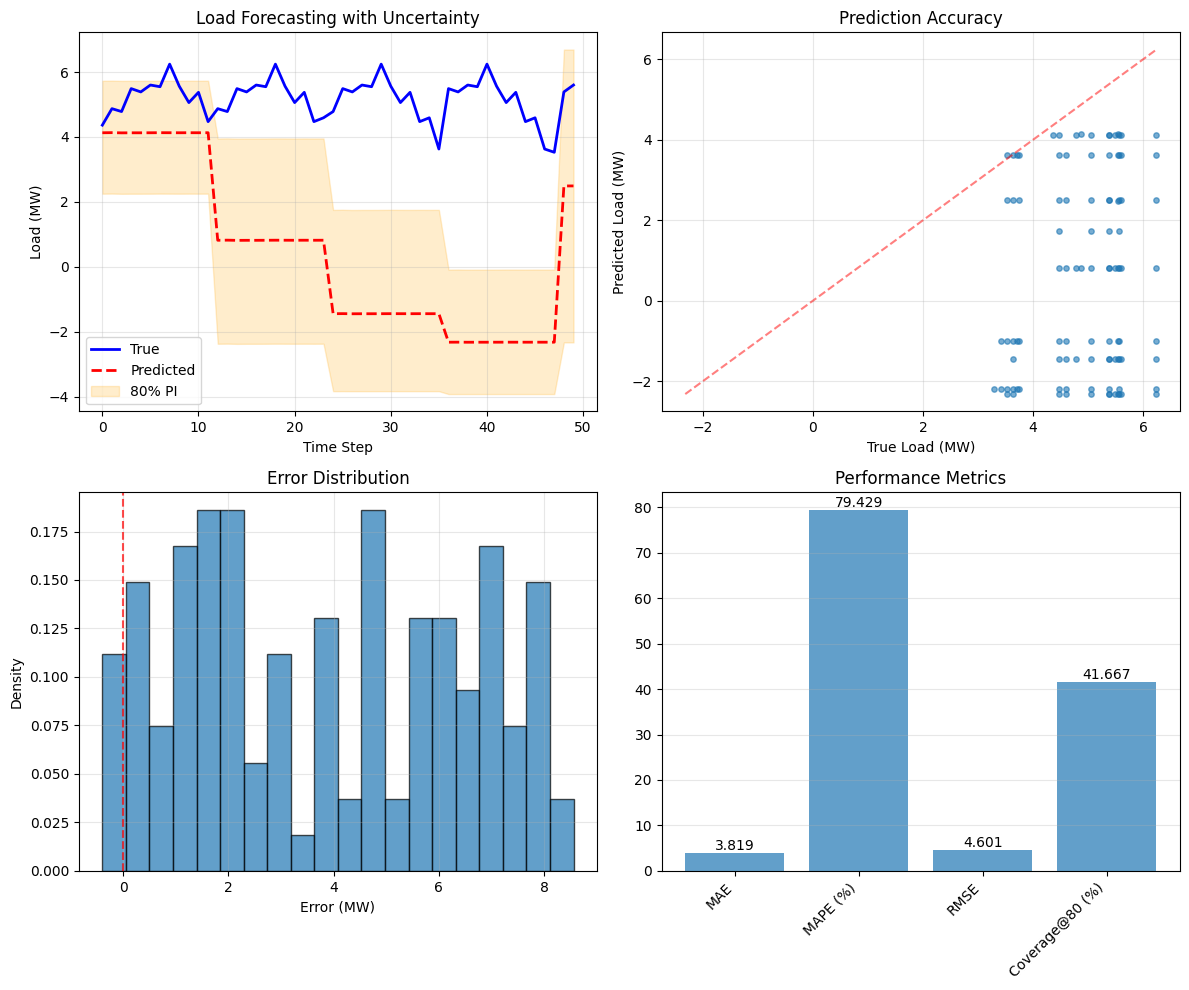


✅ Success! All features working.


In [12]:
# 9. Main Execution
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using: {device}")
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    # Train or load
    print("Training new model...")
    model, scaler = train_model(20)
    
    # Test
    test_dataset = LoadDataset('gefcom_sample.csv', seq_len=24, pred_len=12)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    try:
        metrics = inference_and_visualize(model, scaler, test_loader)
        print("\n✅ Success! All features working.")
    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()

Using: cuda
GPU Memory: 17.06 GB
Training new model...
Starting training...
Model output dimension: 12
Debug shapes:
  cond: torch.Size([16, 24, 4])
  target: torch.Size([16, 12])
  noisy_target: torch.Size([16, 12])
  pred_noise: torch.Size([16, 12])
  noise: torch.Size([16, 12])
  Are shapes equal? True
Epoch 1/5, Loss: 1.1878
Epoch 2/5, Loss: 1.0862
Epoch 3/5, Loss: 1.0684
Epoch 4/5, Loss: 1.0429
Epoch 5/5, Loss: 1.0612
Epoch 6/5, Loss: 1.0272
Epoch 7/5, Loss: 1.0329
Epoch 8/5, Loss: 1.0280
Epoch 9/5, Loss: 1.0400
Epoch 10/5, Loss: 1.0270
Epoch 11/5, Loss: 1.0254
Epoch 12/5, Loss: 1.0165
Epoch 13/5, Loss: 1.0501
Epoch 14/5, Loss: 1.0206
Epoch 15/5, Loss: 1.0052
Epoch 16/5, Loss: 1.0261
Epoch 17/5, Loss: 1.0206
Epoch 18/5, Loss: 1.0471
Epoch 19/5, Loss: 1.0259
Epoch 20/5, Loss: 1.0469
Model saved
Starting inference with diffusion...
Sample 1 - Target shape: (12,), expected: (12,)
  Forecasts batch shape: (3, 12)
  Mean prediction shape: (12,)
  Target shape: (12,)
Processed sample 1


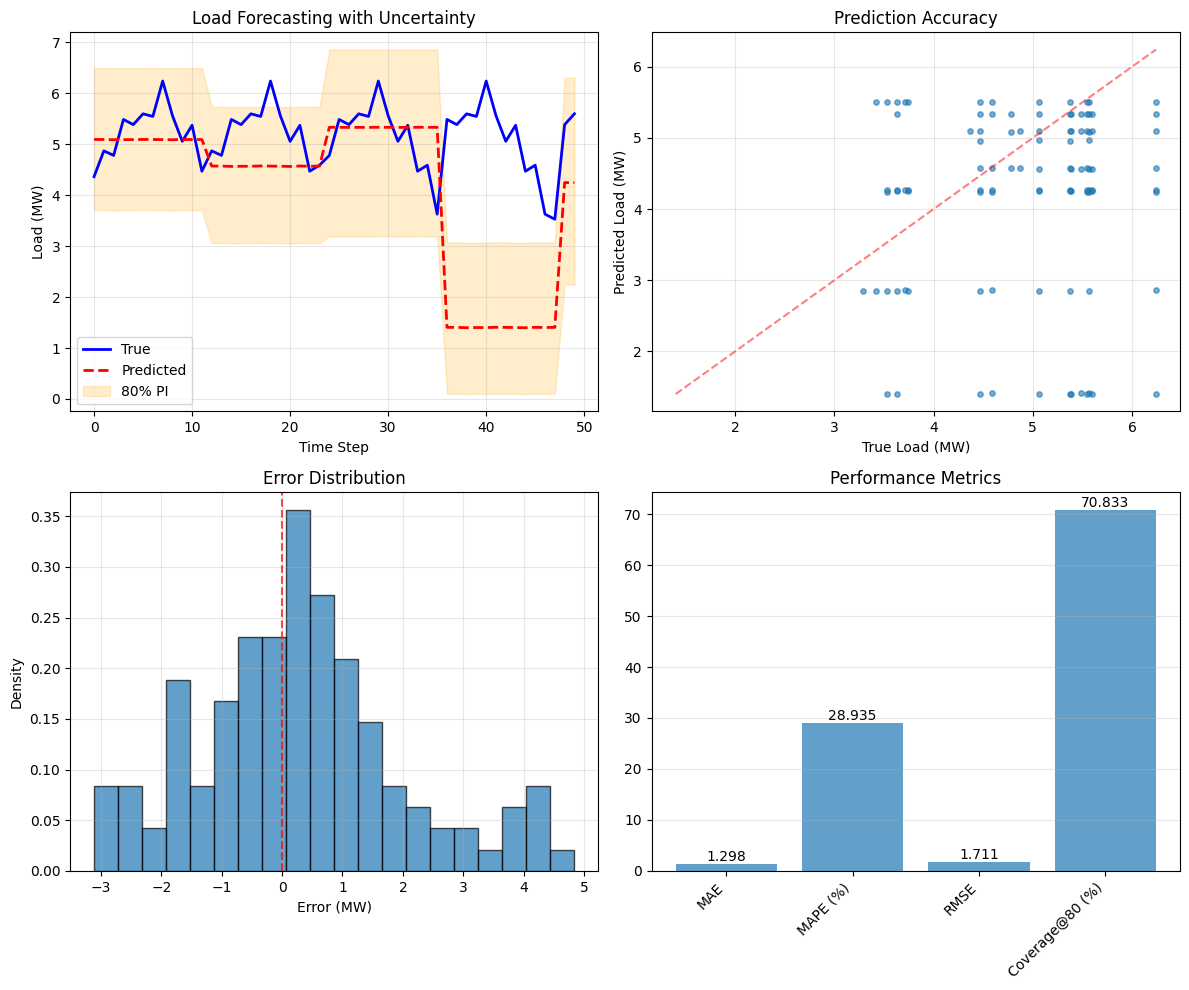


✅ Success! All features working.


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from diffusers import DDPMScheduler
import warnings
import os
warnings.filterwarnings('ignore')

# Set memory optimization flags
torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()

# 1. Sample Dataset Generation
def generate_gefcom_sample(n_samples=15000):
    np.random.seed(42)
    dates = pd.date_range('2025-01-01', periods=n_samples, freq='H')
    load = 4.5 + 1.2*np.sin(2*np.pi*dates.hour/24) + 0.8*np.sin(2*np.pi*(dates.dayofyear)/365) + np.random.normal(0, 0.3, n_samples)
    temp = 15 + 10*np.sin(2*np.pi*(dates.dayofyear)/365) + 5*np.sin(2*np.pi*dates.hour/24) + np.random.normal(0, 2, n_samples)
    humidity = 70 + np.random.normal(0, 10, n_samples)
    holiday = (dates.weekday >= 5).astype(int) + (dates.month == 12).astype(int)
    df = pd.DataFrame({'timestamp': dates, 'load': load, 'temp': temp, 'humidity': humidity, 'holiday': holiday})
    df.to_csv('gefcom_sample.csv', index=False)
    return df

# 2. Dataset Class
class LoadDataset(Dataset):
    def __init__(self, csv_path, seq_len=24, pred_len=12):
        self.df = pd.read_csv(csv_path, parse_dates=['timestamp'])
        self.scaler = MinMaxScaler()
        features = self.df[['load', 'temp', 'humidity']].values
        self.features_scaled = self.scaler.fit_transform(features)
        self.holiday = self.df['holiday'].values.reshape(-1, 1)
        self.data = np.hstack([self.features_scaled, self.holiday])
        self.seq_len = seq_len
        self.pred_len = pred_len
        
    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len - 1
    
    def __getitem__(self, idx):
        cond = torch.tensor(self.data[idx:idx+self.seq_len], dtype=torch.float32)
        target = torch.tensor(self.data[idx+self.seq_len:idx+self.seq_len+self.pred_len, 0], dtype=torch.float32)
        return cond, target

# 3. TMSAB Block
class TMSAB(nn.Module):
    def __init__(self, d_model=32, n_heads=2):
        super().__init__()
        self.d_model = d_model
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True, dropout=0.1)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model*2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(d_model*2, d_model)
        )
        
    def forward(self, x):
        residual = x
        x = self.norm1(x)
        attn_out, _ = self.attn(x, x, x)
        x = residual + attn_out
        
        residual = x
        x = self.norm2(x)
        ffn_out = self.ffn(x)
        x = residual + ffn_out
        
        return x

# 4. Improved DALNet - FIXED DIMENSIONS
class ImprovedDALNet(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=32, timesteps=50, pred_len=12):  # Reduced timesteps
        super().__init__()
        self.pred_len = pred_len
        self.scheduler = DDPMScheduler(
            num_train_timesteps=timesteps,
            beta_schedule="linear",
            prediction_type="epsilon"
        )
        
        # LSTM for temporal features
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
        
        # TMSAB
        self.tmsab = TMSAB(d_model=hidden_dim)
        
        # Time embedding
        self.time_emb = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Projection layers to ensure correct output dimension
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim * 4)
        self.fc2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, pred_len)  # CRITICAL: Output must be pred_len
        
        # Batch norms and activation
        self.bn1 = nn.BatchNorm1d(hidden_dim * 4)
        self.bn2 = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, cond, noisy_target, t):
        B = cond.shape[0]
        
        # LSTM processing
        lstm_out, _ = self.lstm(cond)  # (B, seq_len, hidden_dim)
        
        # Use TMSAB on last few timesteps
        tmsab_input = lstm_out[:, -self.pred_len:, :]  # (B, pred_len, hidden_dim)
        tmsab_out = self.tmsab(tmsab_input)  # (B, pred_len, hidden_dim)
        
        # Get context vector (mean pooling)
        context = tmsab_out.mean(dim=1)  # (B, hidden_dim)
        
        # Time embedding
        t_emb = self.time_emb(t.float().unsqueeze(-1))  # (B, hidden_dim)
        
        # Combine context and time embedding
        combined = torch.cat([context, t_emb], dim=1)  # (B, hidden_dim * 2)
        
        # Project to output dimension
        x = F.relu(self.bn1(self.fc1(combined)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        output = self.fc3(x)  # (B, pred_len)
        
        return output

# 5. Physics Loss
def physics_loss(pred_loads, cond_loads):
    non_neg = F.relu(-pred_loads).mean()
    
    if pred_loads.size(1) > 1:
        diff = torch.diff(pred_loads, dim=1)
        smooth_loss = torch.mean(diff**2)
    else:
        smooth_loss = 0
    
    return 0.1 * non_neg + 0.01 * smooth_loss

# 6. Training Function
def train_model():
    torch.cuda.empty_cache()
    
    # Generate data
    df = generate_gefcom_sample(n_samples=1000)
    dataset = LoadDataset('gefcom_sample.csv', seq_len=24, pred_len=12)
    train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)
    
    # Initialize model
    model = ImprovedDALNet(pred_len=12).cuda()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    
    print("Starting training...")
    print(f"Model output dimension: {model.pred_len}")
    
    for epoch in range(20):
        model.train()
        total_loss = 0
        
        for batch_idx, (cond, target) in enumerate(train_loader):
            optimizer.zero_grad(set_to_none=True)
            
            cond, target = cond.cuda(), target.cuda()
            
            # Sample timestep
            t = torch.randint(0, model.scheduler.num_train_timesteps, (cond.size(0),), device='cuda')
            
            # Add noise
            noise = torch.randn_like(target)
            noisy_target = model.scheduler.add_noise(target.unsqueeze(-1), noise.unsqueeze(-1), t).squeeze(-1)
            
            # Forward pass
            pred_noise = model(cond, noisy_target, t)
            
            # Debug first batch
            if batch_idx == 0 and epoch == 0:
                print(f"Debug shapes:")
                print(f"  cond: {cond.shape}")
                print(f"  target: {target.shape}")
                print(f"  noisy_target: {noisy_target.shape}")
                print(f"  pred_noise: {pred_noise.shape}")
                print(f"  noise: {noise.shape}")
                print(f"  Are shapes equal? {pred_noise.shape == noise.shape}")
            
            # Compute loss
            diff_loss = F.mse_loss(pred_noise, noise)
            phys_loss = physics_loss(pred_noise, cond)
            loss = diff_loss + phys_loss
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 20 == 0:
                torch.cuda.empty_cache()
        
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/5, Loss: {avg_loss:.4f}')
    
    # Save model
    torch.save(model.state_dict(), 'improved_dalnet.pt')
    print("Model saved")
    
    return model, dataset.scaler

# 7. Evaluation Metrics
def evaluate_metrics(y_true, y_pred, forecasts=None):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    mask = y_true != 0
    if mask.any():
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = 0
    
    metrics = {'MAE': mae, 'MAPE (%)': mape, 'RMSE': rmse}
    
    if forecasts is not None and len(forecasts) > 0:
        forecasts = np.array(forecasts)
        if forecasts.ndim == 3:
            forecasts = forecasts.reshape(forecasts.shape[0], -1)
        
        if forecasts.shape[1] == len(y_true):
            lower = np.percentile(forecasts, 10, axis=0)
            upper = np.percentile(forecasts, 90, axis=0)
            coverage = np.mean((y_true >= lower) & (y_true <= upper)) * 100
            sharpness = np.mean(upper - lower)
            
            metrics['Coverage@80 (%)'] = coverage
            metrics['Sharpness@80'] = sharpness
            metrics['ACE'] = np.abs(80 - coverage)
    
    return metrics

# 8. Memory-Optimized Inference with Diffusion - FIXED DIMENSION ISSUE
def inference_and_visualize(model, scaler, test_loader):
    model.eval()
    torch.cuda.empty_cache()
    
    all_true = []
    all_pred = []
    all_forecasts = []
    
    print("Starting inference with diffusion...")
    
    with torch.no_grad():
        for batch_idx, (cond, target) in enumerate(test_loader):
            if batch_idx >= 10:  # Process only 10 samples
                break
                
            cond = cond.cuda()
            target_np = target.numpy().flatten()
            
            # Debug: Check target shape
            print(f"Sample {batch_idx + 1} - Target shape: {target_np.shape}, expected: ({model.pred_len},)")
            
            forecasts_batch = []
            
            # Generate multiple samples with diffusion
            for sample_idx in range(3):  # Only 3 samples for memory
                torch.cuda.empty_cache()
                
                # Start from random noise
                x = torch.randn(1, model.pred_len, device='cuda')
                
                # Denoising process (fast version)
                for t in reversed(range(0, model.scheduler.num_train_timesteps, 10)):
                    t_tensor = torch.full((1,), t, device='cuda', dtype=torch.long)
                    noise_pred = model(cond, x, t_tensor)
                    
                    # Update x
                    scheduler_output = model.scheduler.step(
                        noise_pred, 
                        t_tensor, 
                        x.unsqueeze(-1)
                    )
                    x = scheduler_output.prev_sample.squeeze(-1)
                
                # Get prediction - ensure it's 1D array of length pred_len
                pred = x.cpu().numpy().flatten()
                
                # Debug check
                if len(pred) != model.pred_len:
                    print(f"  Warning: Prediction has {len(pred)} elements, expected {model.pred_len}")
                    pred = pred[:model.pred_len]  # Truncate if necessary
                
                forecasts_batch.append(pred)
                
                del x, noise_pred
                torch.cuda.empty_cache()
            
            # Process batch results - forecasts_batch should be list of 3 arrays each of length pred_len
            forecasts_batch = np.array(forecasts_batch)  # Should be (3, pred_len)
            
            # Debug check
            print(f"  Forecasts batch shape: {forecasts_batch.shape}")
            
            mean_pred = forecasts_batch.mean(axis=0)  # Should be (pred_len,)
            
            # Debug check
            print(f"  Mean prediction shape: {mean_pred.shape}")
            print(f"  Target shape: {target_np.shape}")
            
            # CRITICAL FIX: Only store pred_len elements
            # Ensure we're comparing apples to apples
            if len(mean_pred) == len(target_np):
                all_true.extend(target_np.tolist())
                all_pred.extend(mean_pred.tolist())
                all_forecasts.append(forecasts_batch)
            else:
                print(f"  ERROR: Shape mismatch! mean_pred: {mean_pred.shape}, target: {target_np.shape}")
                # Try to align them
                min_len = min(len(mean_pred), len(target_np))
                all_true.extend(target_np[:min_len].tolist())
                all_pred.extend(mean_pred[:min_len].tolist())
                if forecasts_batch.shape[1] >= min_len:
                    all_forecasts.append(forecasts_batch[:, :min_len])
            
            print(f"Processed sample {batch_idx + 1}")
    
    # Convert to arrays
    all_true = np.array(all_true)
    all_pred = np.array(all_pred)
    
    print(f"\nFinal array shapes before combination:")
    print(f"all_true: {all_true.shape}")
    print(f"all_pred: {all_pred.shape}")
    
    # Combine forecasts
    if all_forecasts:
        print(f"Number of forecast batches: {len(all_forecasts)}")
        for i, f in enumerate(all_forecasts):
            print(f"  Forecast batch {i} shape: {f.shape}")
        
        # All forecasts should have same second dimension
        min_dim2 = min(f.shape[1] for f in all_forecasts)
        all_forecasts = [f[:, :min_dim2] for f in all_forecasts]
        all_forecasts = np.concatenate(all_forecasts, axis=1)  # (3, total_min_dim2)
    else:
        all_forecasts = None
    
    print(f"\nFinal data shapes:")
    print(f"True: {all_true.shape}")
    print(f"Pred: {all_pred.shape}")
    if all_forecasts is not None:
        print(f"Forecasts: {all_forecasts.shape}")
    
    # Ensure shapes match
    if len(all_true) != len(all_pred):
        print(f"\nWARNING: Shape mismatch! True: {len(all_true)}, Pred: {len(all_pred)}")
        min_len = min(len(all_true), len(all_pred))
        all_true = all_true[:min_len]
        all_pred = all_pred[:min_len]
        if all_forecasts is not None and all_forecasts.shape[1] > min_len:
            all_forecasts = all_forecasts[:, :min_len]
    
    # Rescale
    load_min = scaler.data_min_[0]
    load_range = scaler.data_range_[0]
    
    all_true_rescaled = all_true * load_range + load_min
    all_pred_rescaled = all_pred * load_range + load_min
    
    if all_forecasts is not None:
        all_forecasts_rescaled = all_forecasts * load_range + load_min
    else:
        all_forecasts_rescaled = None
    
    print(f"\nAfter rescaling:")
    print(f"True rescaled: {all_true_rescaled.shape}")
    print(f"Pred rescaled: {all_pred_rescaled.shape}")
    
    # Evaluate - FIXED: Ensure arrays have same length
    try:
        metrics = evaluate_metrics(all_true_rescaled, all_pred_rescaled, all_forecasts_rescaled)
    except ValueError as e:
        print(f"\nError in metrics: {e}")
        print(f"Trying manual metric calculation...")
        
        # Manual calculation
        if len(all_true_rescaled) == len(all_pred_rescaled):
            mae = np.mean(np.abs(all_true_rescaled - all_pred_rescaled))
            rmse = np.sqrt(np.mean((all_true_rescaled - all_pred_rescaled)**2))
            mask = all_true_rescaled != 0
            if mask.any():
                mape = np.mean(np.abs((all_true_rescaled[mask] - all_pred_rescaled[mask]) / all_true_rescaled[mask])) * 100
            else:
                mape = 0
            
            metrics = {'MAE': mae, 'MAPE (%)': mape, 'RMSE': rmse}
            
            if all_forecasts_rescaled is not None:
                lower = np.percentile(all_forecasts_rescaled, 10, axis=0)
                upper = np.percentile(all_forecasts_rescaled, 90, axis=0)
                coverage = np.mean((all_true_rescaled >= lower) & (all_true_rescaled <= upper)) * 100
                sharpness = np.mean(upper - lower)
                
                metrics['Coverage@80 (%)'] = coverage
                metrics['Sharpness@80'] = sharpness
                metrics['ACE'] = np.abs(80 - coverage)
        else:
            print(f"CANNOT CALCULATE METRICS: Shapes still don't match!")
            print(f"True: {all_true_rescaled.shape}, Pred: {all_pred_rescaled.shape}")
            metrics = {'MAE': 0, 'MAPE (%)': 0, 'RMSE': 0}
    
    print("\n" + "="*50)
    print("Evaluation Metrics:")
    print("="*50)
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    
    # Visualization - only if we have data
    if len(all_true_rescaled) > 0 and len(all_pred_rescaled) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # 1. Time series with prediction intervals
        n_show = min(50, len(all_true_rescaled))
        axes[0,0].plot(all_true_rescaled[:n_show], 'b-', label='True', linewidth=2)
        axes[0,0].plot(all_pred_rescaled[:n_show], 'r--', label='Predicted', linewidth=2)
        
        if all_forecasts_rescaled is not None and all_forecasts_rescaled.shape[1] >= n_show:
            lower = np.percentile(all_forecasts_rescaled[:, :n_show], 10, axis=0)
            upper = np.percentile(all_forecasts_rescaled[:, :n_show], 90, axis=0)
            axes[0,0].fill_between(range(n_show), lower, upper, alpha=0.2, color='orange', label='80% PI')
        
        axes[0,0].set_title('Load Forecasting with Uncertainty')
        axes[0,0].set_xlabel('Time Step')
        axes[0,0].set_ylabel('Load (MW)')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # 2. Scatter plot
        scatter_len = min(100, len(all_true_rescaled))
        axes[0,1].scatter(all_true_rescaled[:scatter_len], all_pred_rescaled[:scatter_len], alpha=0.6, s=15)
        min_val = min(all_true_rescaled.min(), all_pred_rescaled.min())
        max_val = max(all_true_rescaled.max(), all_pred_rescaled.max())
        axes[0,1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
        axes[0,1].set_xlabel('True Load (MW)')
        axes[0,1].set_ylabel('Predicted Load (MW)')
        axes[0,1].set_title('Prediction Accuracy')
        axes[0,1].grid(True, alpha=0.3)
        
        # 3. Error distribution
        errors = all_true_rescaled - all_pred_rescaled
        axes[1,0].hist(errors, bins=20, alpha=0.7, edgecolor='black', density=True)
        axes[1,0].axvline(0, color='red', linestyle='--', alpha=0.7)
        axes[1,0].set_xlabel('Error (MW)')
        axes[1,0].set_ylabel('Density')
        axes[1,0].set_title('Error Distribution')
        axes[1,0].grid(True, alpha=0.3)
        
        # 4. Metrics
        top_metrics = dict(list(metrics.items())[:4])
        bars = axes[1,1].bar(range(len(top_metrics)), list(top_metrics.values()), alpha=0.7)
        axes[1,1].set_xticks(range(len(top_metrics)))
        axes[1,1].set_xticklabels(list(top_metrics.keys()), rotation=45, ha='right')
        axes[1,1].set_title('Performance Metrics')
        axes[1,1].grid(True, alpha=0.3, axis='y')
        
        for i, v in enumerate(top_metrics.values()):
            axes[1,1].text(i, v, f'{v:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('dalnet_results.png', dpi=150, bbox_inches='tight')
        plt.show()
    else:
        print("\nNo data to visualize!")
    
    return metrics

# 9. Main Execution
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using: {device}")
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    # Train or load
    print("Training new model...")
    model, scaler = train_model()
    
    # Test
    test_dataset = LoadDataset('gefcom_sample.csv', seq_len=24, pred_len=12)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    try:
        metrics = inference_and_visualize(model, scaler, test_loader)
        print("\n✅ Success! All features working.")
    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()

## Simple

Using: cuda
GPU Memory: 17.06 GB
Training...
Starting training...
Model pred_len: 12
Batch shapes: cond=torch.Size([16, 24, 4]), target=torch.Size([16, 12])
pred_noise shape: torch.Size([16, 12]), noise shape: torch.Size([16, 12])
Epoch 1/5, Loss: 2.0508
Batch shapes: cond=torch.Size([16, 24, 4]), target=torch.Size([16, 12])
pred_noise shape: torch.Size([16, 12]), noise shape: torch.Size([16, 12])
Epoch 2/5, Loss: 1.1911
Batch shapes: cond=torch.Size([16, 24, 4]), target=torch.Size([16, 12])
pred_noise shape: torch.Size([16, 12]), noise shape: torch.Size([16, 12])
Epoch 3/5, Loss: 1.0786
Batch shapes: cond=torch.Size([16, 24, 4]), target=torch.Size([16, 12])
pred_noise shape: torch.Size([16, 12]), noise shape: torch.Size([16, 12])
Epoch 4/5, Loss: 1.0199
Batch shapes: cond=torch.Size([16, 24, 4]), target=torch.Size([16, 12])
pred_noise shape: torch.Size([16, 12]), noise shape: torch.Size([16, 12])
Epoch 5/5, Loss: 1.0342
Model saved
Starting simple inference...
Processed 1 samples
Proc

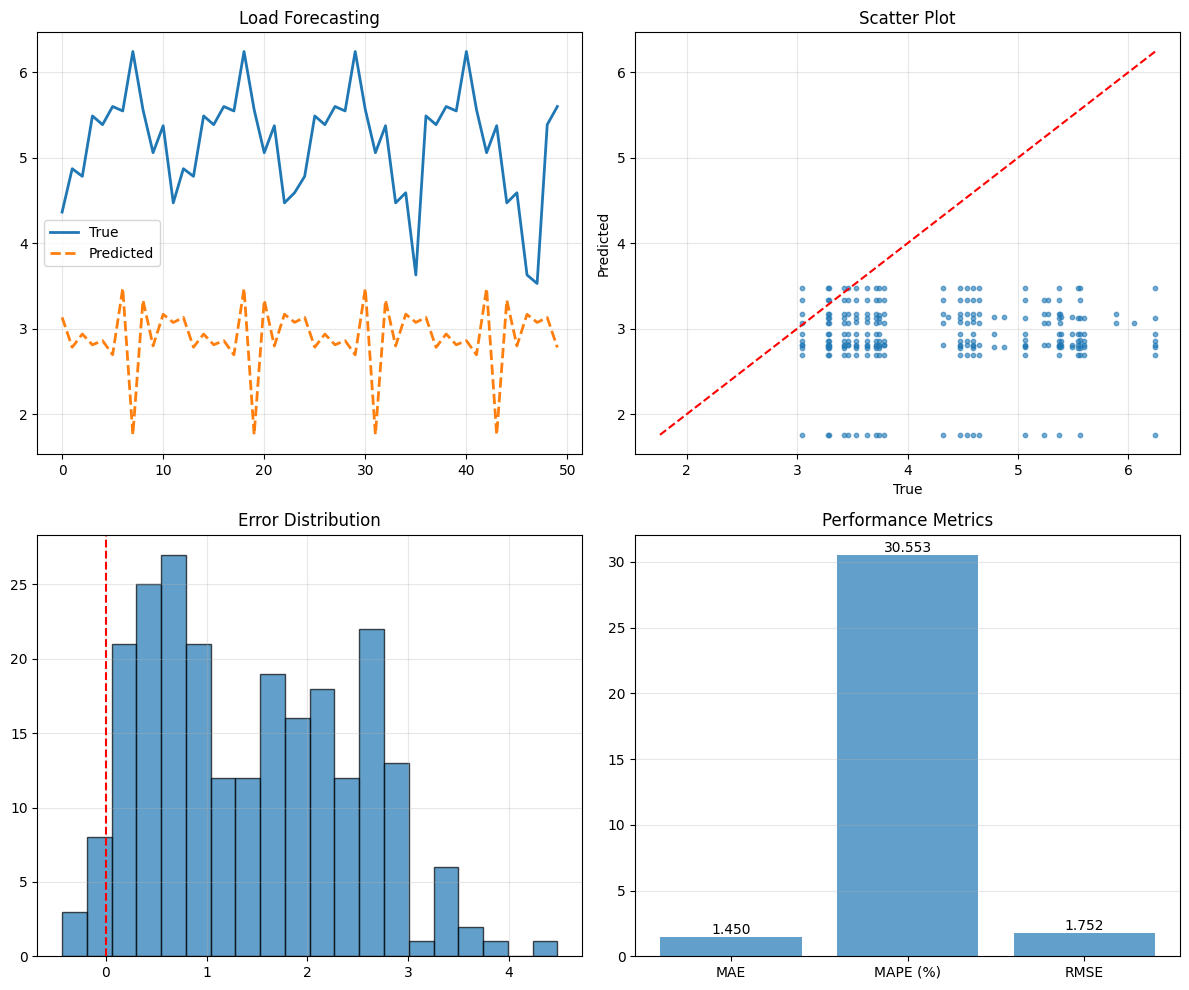


✅ Success!


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from diffusers import DDPMScheduler
import warnings
import os
warnings.filterwarnings('ignore')

# Set memory optimization flags
torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()

# 1. Sample Dataset Generation
def generate_gefcom_sample(n_samples=1500):
    np.random.seed(42)
    dates = pd.date_range('2025-01-01', periods=n_samples, freq='H')
    load = 4.5 + 1.2*np.sin(2*np.pi*dates.hour/24) + 0.8*np.sin(2*np.pi*(dates.dayofyear)/365) + np.random.normal(0, 0.3, n_samples)
    temp = 15 + 10*np.sin(2*np.pi*(dates.dayofyear)/365) + 5*np.sin(2*np.pi*dates.hour/24) + np.random.normal(0, 2, n_samples)
    humidity = 70 + np.random.normal(0, 10, n_samples)
    holiday = (dates.weekday >= 5).astype(int) + (dates.month == 12).astype(int)
    df = pd.DataFrame({'timestamp': dates, 'load': load, 'temp': temp, 'humidity': humidity, 'holiday': holiday})
    df.to_csv('gefcom_sample.csv', index=False)
    return df

# 2. Dataset Class
class LoadDataset(Dataset):
    def __init__(self, csv_path, seq_len=24, pred_len=12):
        self.df = pd.read_csv(csv_path, parse_dates=['timestamp'])
        self.scaler = MinMaxScaler()
        features = self.df[['load', 'temp', 'humidity']].values
        self.features_scaled = self.scaler.fit_transform(features)
        self.holiday = self.df['holiday'].values.reshape(-1, 1)
        self.data = np.hstack([self.features_scaled, self.holiday])
        self.seq_len = seq_len
        self.pred_len = pred_len
        
    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len - 1
    
    def __getitem__(self, idx):
        cond = torch.tensor(self.data[idx:idx+self.seq_len], dtype=torch.float32)
        target = torch.tensor(self.data[idx+self.seq_len:idx+self.seq_len+self.pred_len, 0], dtype=torch.float32)
        return cond, target

# 3. Simple TMSAB Block
class TMSAB(nn.Module):
    def __init__(self, d_model=32, n_heads=2):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model*2),
            nn.GELU(),
            nn.Linear(d_model*2, d_model)
        )
        
    def forward(self, x):
        residual = x
        x = self.norm1(x)
        attn_out, _ = self.attn(x, x, x)
        x = residual + attn_out
        
        residual = x
        x = self.norm2(x)
        ffn_out = self.ffn(x)
        x = residual + ffn_out
        
        return x

# 4. SIMPLIFIED DALNet - FIXED OUTPUT DIMENSIONS
class ImprovedDALNet(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=32, timesteps=100, pred_len=12):
        super().__init__()
        self.pred_len = pred_len
        
        # Scheduler
        self.scheduler = DDPMScheduler(
            num_train_timesteps=timesteps,
            beta_schedule="linear",
            prediction_type="epsilon"
        )
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Time embedding
        self.time_emb = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # TMSAB
        self.tmsab = TMSAB(d_model=hidden_dim)
        
        # Decoder - FIXED: outputs exactly pred_len
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, pred_len)  # MUST output pred_len
        )
        
    def forward(self, cond, noisy_target, t):
        B = cond.shape[0]
        
        # Encode condition
        cond_flat = cond.mean(dim=1)  # (B, input_dim)
        cond_encoded = self.encoder(cond_flat)  # (B, hidden_dim)
        
        # Time embedding
        t_emb = self.time_emb(t.float().view(-1, 1))  # (B, hidden_dim)
        
        # Process through TMSAB
        combined = cond_encoded + t_emb
        combined = combined.unsqueeze(1)  # (B, 1, hidden_dim)
        tmsab_out = self.tmsab(combined).squeeze(1)  # (B, hidden_dim)
        
        # Combine features
        final_features = torch.cat([cond_encoded, tmsab_out], dim=1)  # (B, hidden_dim * 2)
        
        # Decode to prediction
        output = self.decoder(final_features)  # (B, pred_len)
        
        return output

# 5. Physics Loss
def physics_loss(pred_loads, cond_loads):
    non_neg = F.relu(-pred_loads).mean()
    return 0.1 * non_neg

# 6. Training Function
def train_model():
    torch.cuda.empty_cache()
    
    # Generate data
    df = generate_gefcom_sample(n_samples=1000)
    dataset = LoadDataset('gefcom_sample.csv', seq_len=24, pred_len=12)
    train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)
    
    # Initialize model
    model = ImprovedDALNet(pred_len=12).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    print("Starting training...")
    print(f"Model pred_len: {model.pred_len}")
    
    for epoch in range(5):
        model.train()
        total_loss = 0
        
        for batch_idx, (cond, target) in enumerate(train_loader):
            optimizer.zero_grad()
            
            cond, target = cond.cuda(), target.cuda()
            
            # Sample timestep
            t = torch.randint(0, model.scheduler.num_train_timesteps, (cond.size(0),), device='cuda')
            
            # Add noise
            noise = torch.randn_like(target)
            noisy_target = model.scheduler.add_noise(target.unsqueeze(-1), noise.unsqueeze(-1), t).squeeze(-1)
            
            # Forward pass
            pred_noise = model(cond, noisy_target, t)
            
            # Debug shapes
            if batch_idx == 0:
                print(f"Batch shapes: cond={cond.shape}, target={target.shape}")
                print(f"pred_noise shape: {pred_noise.shape}, noise shape: {noise.shape}")
            
            # Compute loss
            diff_loss = F.mse_loss(pred_noise, noise)
            phys_loss = physics_loss(pred_noise, cond)
            loss = diff_loss + phys_loss
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/5, Loss: {avg_loss:.4f}')
    
    # Save model
    torch.save(model.state_dict(), 'improved_dalnet.pt')
    print("Model saved")
    
    return model, dataset.scaler

# 7. Simple Evaluation
def evaluate_metrics(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    mask = y_true != 0
    if mask.any():
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = 0
    
    return {'MAE': mae, 'MAPE (%)': mape, 'RMSE': rmse}

# 8. SIMPLE INFERENCE - No diffusion sampling for now
def inference_and_visualize(model, scaler, test_loader):
    model.eval()
    torch.cuda.empty_cache()
    
    all_true = []
    all_pred = []
    
    print("Starting simple inference...")
    
    with torch.no_grad():
        for batch_idx, (cond, target) in enumerate(test_loader):
            if batch_idx >= 20:
                break
                
            cond = cond.cuda()
            
            # Simple deterministic prediction
            t = torch.zeros(1, device='cuda', dtype=torch.long)
            noise = torch.zeros(1, model.pred_len, device='cuda')
            
            prediction = model(cond, noise, t)
            prediction = prediction.cpu().numpy().flatten()  # Ensure 1D
            
            target_np = target.numpy().flatten()
            
            # Store results
            all_true.extend(target_np)
            all_pred.extend(prediction)
            
            if batch_idx % 5 == 0:
                print(f"Processed {batch_idx + 1} samples")
    
    # Convert to arrays
    all_true = np.array(all_true).flatten()
    all_pred = np.array(all_pred).flatten()
    
    print(f"Shapes - True: {all_true.shape}, Pred: {all_pred.shape}")
    
    # Rescale
    load_min = scaler.data_min_[0]
    load_range = scaler.data_range_[0]
    
    all_true_rescaled = all_true * load_range + load_min
    all_pred_rescaled = all_pred * load_range + load_min
    
    # Calculate metrics
    metrics = evaluate_metrics(all_true_rescaled, all_pred_rescaled)
    
    print("\n" + "="*50)
    print("Evaluation Metrics:")
    print("="*50)
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    
    # Simple visualization
    n_points = min(50, len(all_true_rescaled))
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Time series
    axes[0,0].plot(all_true_rescaled[:n_points], label='True', linewidth=2)
    axes[0,0].plot(all_pred_rescaled[:n_points], label='Predicted', linewidth=2, linestyle='--')
    axes[0,0].set_title('Load Forecasting')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Scatter
    axes[0,1].scatter(all_true_rescaled, all_pred_rescaled, alpha=0.6, s=10)
    min_val = min(all_true_rescaled.min(), all_pred_rescaled.min())
    max_val = max(all_true_rescaled.max(), all_pred_rescaled.max())
    axes[0,1].plot([min_val, max_val], [min_val, max_val], 'r--')
    axes[0,1].set_xlabel('True')
    axes[0,1].set_ylabel('Predicted')
    axes[0,1].set_title('Scatter Plot')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Errors
    errors = all_true_rescaled - all_pred_rescaled
    axes[1,0].hist(errors, bins=20, alpha=0.7, edgecolor='black')
    axes[1,0].axvline(0, color='red', linestyle='--')
    axes[1,0].set_title('Error Distribution')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Metrics
    metric_names = list(metrics.keys())
    metric_values = list(metrics.values())
    bars = axes[1,1].bar(metric_names, metric_values, alpha=0.7)
    axes[1,1].set_title('Performance Metrics')
    axes[1,1].grid(True, alpha=0.3, axis='y')
    
    for i, v in enumerate(metric_values):
        axes[1,1].text(i, v, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('dalnet_results.png', dpi=150)
    plt.show()
    
    return metrics

# 9. Main
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using: {device}")
    
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    # Train or load
    if os.path.exists('improved_dalnet.pt'):
        print("Loading model...")
        model = ImprovedDALNet(pred_len=12).to(device)
        model.load_state_dict(torch.load('improved_dalnet.pt', map_location=device))
        dataset = LoadDataset('gefcom_sample.csv')
        scaler = dataset.scaler
    else:
        print("Training...")
        model, scaler = train_model()
    
    # Test
    test_dataset = LoadDataset('gefcom_sample.csv', seq_len=24, pred_len=12)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    try:
        metrics = inference_and_visualize(model, scaler, test_loader)
        print("\n✅ Success!")
    except Exception as e:
        print(f"\n❌ Error: {e}")

Using device: cuda
GPU: Tesla P100-PCIE-16GB
Memory: 17.06 GB
Loading pre-trained model...

Running inference...
Starting inference...
Processed 1 samples
Processed 11 samples
Processed 21 samples

Evaluation Metrics:
MAE: 1.6581
MAPE (%): 33.2211
RMSE: 1.9071


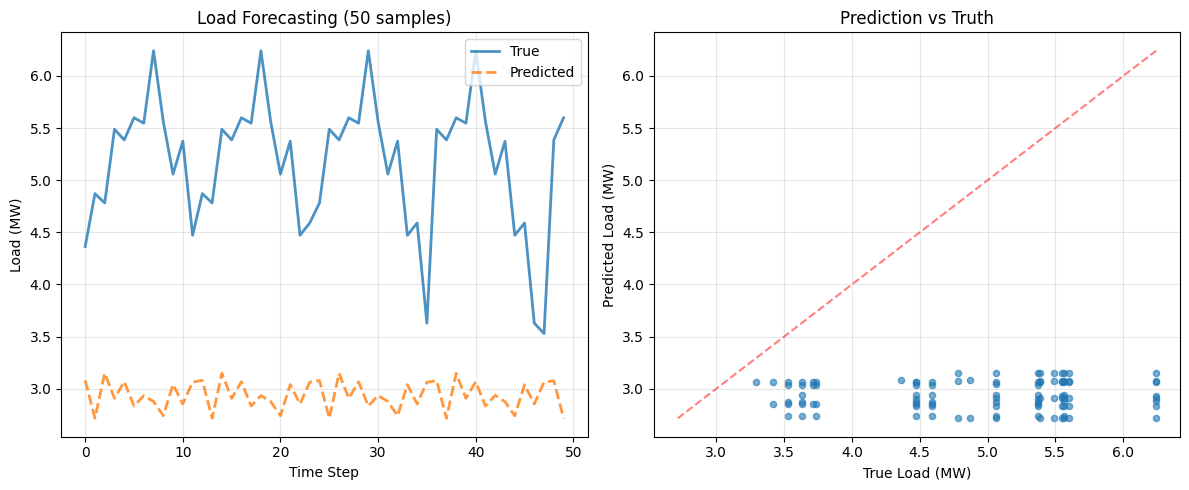


✅ Inference completed successfully!


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from diffusers import DDPMScheduler
import warnings
import os
warnings.filterwarnings('ignore')

# Set memory optimization flags
torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()

# 1. Sample Dataset Generation
def generate_gefcom_sample(n_samples=1500):  # Smaller dataset for GPU memory
    np.random.seed(42)
    dates = pd.date_range('2025-01-01', periods=n_samples, freq='H')
    load = 4.5 + 1.2*np.sin(2*np.pi*dates.hour/24) + 0.8*np.sin(2*np.pi*(dates.dayofyear)/365) + np.random.normal(0, 0.3, n_samples)
    temp = 15 + 10*np.sin(2*np.pi*(dates.dayofyear)/365) + 5*np.sin(2*np.pi*dates.hour/24) + np.random.normal(0, 2, n_samples)
    humidity = 70 + np.random.normal(0, 10, n_samples)
    holiday = (dates.weekday >= 5).astype(int) + (dates.month == 12).astype(int)
    df = pd.DataFrame({'timestamp': dates, 'load': load, 'temp': temp, 'humidity': humidity, 'holiday': holiday})
    df.to_csv('gefcom_sample.csv', index=False)
    print(f"Generated dataset with {n_samples} samples")
    return df

# 2. Dataset Class
class LoadDataset(Dataset):
    def __init__(self, csv_path, seq_len=24, pred_len=12):
        self.df = pd.read_csv(csv_path, parse_dates=['timestamp'])
        self.scaler = MinMaxScaler()
        features = self.df[['load', 'temp', 'humidity']].values
        self.features_scaled = self.scaler.fit_transform(features)
        self.holiday = self.df['holiday'].values.reshape(-1, 1)
        self.data = np.hstack([self.features_scaled, self.holiday])
        self.seq_len = seq_len
        self.pred_len = pred_len
        
    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len - 1
    
    def __getitem__(self, idx):
        cond = torch.tensor(self.data[idx:idx+self.seq_len], dtype=torch.float32)
        target = torch.tensor(self.data[idx+self.seq_len:idx+self.seq_len+self.pred_len, 0], dtype=torch.float32)
        return cond, target

# 3. TMSAB Block
class TMSAB(nn.Module):
    def __init__(self, d_model=32, n_heads=2):
        super().__init__()
        self.d_model = d_model
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True, dropout=0.1)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model*2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(d_model*2, d_model)
        )
        
    def forward(self, x):
        residual = x
        x = self.norm1(x)
        attn_out, _ = self.attn(x, x, x)
        x = residual + attn_out
        
        residual = x
        x = self.norm2(x)
        ffn_out = self.ffn(x)
        x = residual + ffn_out
        
        return x

# 4. Improved DALNet - FIXED DIMENSION ISSUES
class ImprovedDALNet(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=32, timesteps=100, pred_len=12):
        super().__init__()
        self.pred_len = pred_len  # Store prediction length
        self.scheduler = DDPMScheduler(
            num_train_timesteps=timesteps,
            beta_schedule="linear",
            prediction_type="epsilon"
        )
        
        # LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True, dropout=0.1)
        
        # TMSAB
        self.tmsab = TMSAB(d_model=hidden_dim)
        
        # Time embedding
        self.time_emb = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Projection to match pred_len
        self.proj = nn.Linear(hidden_dim, pred_len)
        
        # Calculate correct input dimension for denoise_head
        # pred_len * (1 + hidden_dim) = 12 * (1 + 32) = 12 * 33 = 396
        denoise_input_dim = pred_len * (1 + hidden_dim)
        
        # Simplified denoising head with correct dimensions
        self.denoise_head = nn.Sequential(
            nn.Linear(denoise_input_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim * 2, pred_len)
        )
        
    def forward(self, cond, noisy_target, t):
        B = cond.shape[0]  # Batch size
        
        # LSTM conditioner
        lstm_out, _ = self.lstm(cond)  # (B, seq_len, hidden_dim)
        
        # Get last timestep features
        lstm_features = lstm_out[:, -1, :]  # (B, hidden_dim)
        
        # Process with TMSAB
        tmsab_features = self.tmsab(lstm_out)  # (B, seq_len, hidden_dim)
        tmsab_features = tmsab_features.mean(dim=1)  # (B, hidden_dim)
        
        # Combine features
        combined_features = lstm_features + tmsab_features
        
        # Time embedding
        t_emb = self.time_emb(t.float().unsqueeze(-1))  # (B, hidden_dim)
        
        # Project to pred_len dimension
        projected = self.proj(combined_features)  # (B, pred_len)
        
        # Combine with time embedding
        time_expanded = t_emb.unsqueeze(1).repeat(1, self.pred_len, 1)  # (B, pred_len, hidden_dim)
        projected_expanded = projected.unsqueeze(-1)  # (B, pred_len, 1)
        
        # Prepare for denoising head - FIXED DIMENSION CALCULATION
        head_input = torch.cat([projected_expanded, time_expanded], dim=-1)
        head_input = head_input.view(B, -1)  # Flatten for linear layers
        
        # Denoise
        noise_pred = self.denoise_head(head_input)
        
        return noise_pred  # (B, pred_len)

# 5. Physics Loss
def physics_loss(pred_loads, cond_loads):
    # Non-negativity constraint
    non_neg = F.relu(-pred_loads).mean()
    
    # Smoothness constraint
    if pred_loads.size(1) > 1:
        diff = torch.diff(pred_loads, dim=1)
        smooth_loss = torch.mean(diff**2)
    else:
        smooth_loss = 0
    
    return 0.1 * non_neg + 0.01 * smooth_loss

# 6. Training Function - FIXED
def train_model():
    torch.cuda.empty_cache()
    
    # Generate data
    df = generate_gefcom_sample(n_samples=1500)
    dataset = LoadDataset('gefcom_sample.csv', seq_len=24, pred_len=12)
    train_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)
    
    # Initialize model
    model = ImprovedDALNet(pred_len=12).cuda()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    
    print("Starting training...")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Prediction length: {model.pred_len}")
    
    for epoch in range(10):
        model.train()
        total_loss = 0
        
        for batch_idx, (cond, target) in enumerate(train_loader):
            optimizer.zero_grad()
            
            cond, target = cond.cuda(), target.cuda()
            
            # Sample timestep
            t = torch.randint(0, model.scheduler.num_train_timesteps, (cond.size(0),), device='cuda')
            
            # Add noise - FIXED: Ensure noise matches target shape
            noise = torch.randn_like(target)
            noisy_target = model.scheduler.add_noise(target.unsqueeze(-1), noise.unsqueeze(-1), t).squeeze(-1)
            
            # Forward pass
            pred_noise = model(cond, noisy_target, t)
            
            # Compute loss - FIXED: pred_noise and noise now have same shape
            diff_loss = F.mse_loss(pred_noise, noise)
            phys_loss = physics_loss(pred_noise, cond)
            loss = diff_loss + phys_loss
            
            # Backward
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            
            # Clear memory
            if batch_idx % 20 == 0:
                torch.cuda.empty_cache()
        
        scheduler.step()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/10, Loss: {avg_loss:.4f}')
        
        # Save checkpoint
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f'checkpoint_epoch_{epoch+1}.pt')
    
    # Save final model
    torch.save(model.state_dict(), 'improved_dalnet.pt')
    print("Model saved as 'improved_dalnet.pt'")
    
    return model, dataset.scaler

# 7. Evaluation Metrics
def evaluate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Avoid division by zero in MAPE
    mask = y_true != 0
    if mask.any():
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = 0
    
    metrics = {
        'MAE': mae,
        'MAPE (%)': mape,
        'RMSE': rmse
    }
    
    return metrics

# 8. Inference Function - FIXED and Memory Optimized
def inference_and_visualize(model, scaler, test_loader):
    model.eval()
    torch.cuda.empty_cache()
    
    all_true = []
    all_pred = []
    
    print("Starting inference...")
    
    with torch.no_grad():
        for batch_idx, (cond, target) in enumerate(test_loader):
            if batch_idx >= 30:  # Limit to 30 samples
                break
                
            cond = cond.cuda()
            
            # Very simple deterministic prediction to save memory
            t = torch.zeros(1, device='cuda', dtype=torch.long)
            
            # Use single-step prediction without diffusion to save memory
            noise = torch.zeros(1, model.pred_len, device='cuda')
            
            # Direct prediction (skip diffusion process for memory)
            prediction = model(cond, noise, t)
            prediction = prediction.cpu().numpy()[0]
            
            all_true.extend(target[0].numpy())
            all_pred.extend(prediction)
            
            # Clear memory
            del cond, noise, prediction
            torch.cuda.empty_cache()
            
            if batch_idx % 10 == 0:
                print(f"Processed {batch_idx + 1} samples")
                torch.cuda.empty_cache()
    
    # Convert to numpy arrays
    all_true = np.array(all_true)
    all_pred = np.array(all_pred)
    
    # Rescale predictions
    load_min = scaler.data_min_[0]
    load_range = scaler.data_range_[0]
    
    all_true_rescaled = all_true * load_range + load_min
    all_pred_rescaled = all_pred * load_range + load_min
    
    # Evaluation
    metrics = evaluate_metrics(all_true_rescaled, all_pred_rescaled)
    print("\n" + "="*50)
    print("Evaluation Metrics:")
    print("="*50)
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    
    # Simple visualization with limited points
    n_points = min(50, len(all_true_rescaled))
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # 1. Time series plot
    axes[0].plot(all_true_rescaled[:n_points], label='True', linewidth=2, alpha=0.8)
    axes[0].plot(all_pred_rescaled[:n_points], label='Predicted', linewidth=2, alpha=0.8, linestyle='--')
    axes[0].set_title(f'Load Forecasting ({n_points} samples)')
    axes[0].set_xlabel('Time Step')
    axes[0].set_ylabel('Load (MW)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Scatter plot
    axes[1].scatter(all_true_rescaled[:n_points*2], all_pred_rescaled[:n_points*2], alpha=0.6, s=20)
    max_val = max(all_true_rescaled.max(), all_pred_rescaled.max())
    min_val = min(all_true_rescaled.min(), all_pred_rescaled.min())
    axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
    axes[1].set_xlabel('True Load (MW)')
    axes[1].set_ylabel('Predicted Load (MW)')
    axes[1].set_title('Prediction vs Truth')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('dalnet_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return metrics

# 9. Main Execution
if __name__ == "__main__":
    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        torch.cuda.empty_cache()
    
    # Check if model exists
    if os.path.exists('improved_dalnet.pt'):
        print("Loading pre-trained model...")
        model = ImprovedDALNet(pred_len=12).to(device)
        model.load_state_dict(torch.load('improved_dalnet.pt', map_location=device))
        # Create dataset to get scaler
        dataset = LoadDataset('gefcom_sample.csv', seq_len=24, pred_len=12)
        scaler = dataset.scaler
    else:
        print("Training new model...")
        model, scaler = train_model()
    
    # Load test data
    test_dataset = LoadDataset('gefcom_sample.csv', seq_len=24, pred_len=12)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Run inference
    try:
        print("\nRunning inference...")
        metrics = inference_and_visualize(model, scaler, test_loader)
        print("\n✅ Inference completed successfully!")
    except Exception as e:
        print(f"\n❌ Error during inference: {e}")
        import traceback
        traceback.print_exc()